In [2]:
# Cell 1: Python
# Setup: Imports and Global Configurations
import music21 as m21
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import glob
import time # For timing operations
import tqdm

# Configure plots for better readability
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis") # Setting a nice color palette
FIG_SIZE = (12, 6) # Default figure size for plots
SMALL_FIG_SIZE = (10, 4)

# Path to the MAESTRO dataset (assuming it's in a 'data/' subdirectory)
# IMPORTANT: Replace with the actual path to your unzipped MAESTRO dataset
MAESTRO_DATA_PATH = '../data/' # Or 'data/maestro-v2.0.0', etc.

# For reproducibility of any sampling, though less critical for EDA
# np.random.seed(42)

print(f"Music21 version: {m21.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Music21 version: 9.7.0
Pandas version: 2.2.3
Numpy version: 1.26.4
Matplotlib version: 3.8.2
Seaborn version: 0.13.2


In [3]:
METADATA_FILE = os.path.join(MAESTRO_DATA_PATH, 'maestro-v3.0.0.csv')

# Load the metadata
metadata_df = None
try:
    metadata_df = pd.read_csv(METADATA_FILE)
    print("Successfully loaded metadata.")
    print("First 5 rows of the metadata:")
    print(metadata_df.head())
    print(f"\nShape of metadata: {metadata_df.shape}")
    print("\nColumns in metadata:")
    print(metadata_df.columns)
except FileNotFoundError:
    print(f"Error: Metadata file not found at {METADATA_FILE}")
    print("Please ensure the MAESTRO dataset (v3.0.0 or compatible) is downloaded, unzipped,")
    print("and the 'maestro-v3.0.0.csv' file is located in the 'data/' directory.")
    # In a real script, one might raise an exception or exit here.
    # For a notebook, execution might continue, but subsequent cells will fail.
except Exception as e:
    print(f"An error occurred while loading the metadata: {e}")

# Proceed with analysis only if metadata_df is loaded
if metadata_df is not None:
    # Further analysis code will go here
    pass

Successfully loaded metadata.
First 5 rows of the metadata:
   canonical_composer                canonical_title       split  year  \
0          Alban Berg                   Sonata Op. 1       train  2018   
1          Alban Berg                   Sonata Op. 1       train  2008   
2          Alban Berg                   Sonata Op. 1       train  2017   
3  Alexander Scriabin  24 Preludes Op. 11, No. 13-24       train  2004   
4  Alexander Scriabin               3 Etudes, Op. 65  validation  2006   

                                       midi_filename  \
0  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...   
1  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...   
2  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...   
3  2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...   
4  2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...   

                                      audio_filename    duration  
0  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  698.661160  
1  2008/MIDI-Unprocessed


Dataset Split Counts:
split
train         962
test          177
validation    137
Name: count, dtype: int64

Total Duration (seconds) per Split:
split
test           71927.921195
train         573277.442251
validation     69946.183203
Name: duration, dtype: float64
Total dataset duration: 198.65 hours

Number of Unique Composers (Overall):
Total unique composers: 60

Table 1: MAESTRO Dataset Split Summary
        Split  Number of MIDI files  Total Duration (hours)  Number of Unique Composers
0       train                   962                  159.24                          58
1  validation                   137                   19.43                          16
2        test                   177                   19.98                          16


/var/folders/68/hvp2t7gj06n533xy7nxc0y_w0000gn/T/ipykernel_3425/4146810422.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata_df, x='split', order=plot_order, palette="viridis")


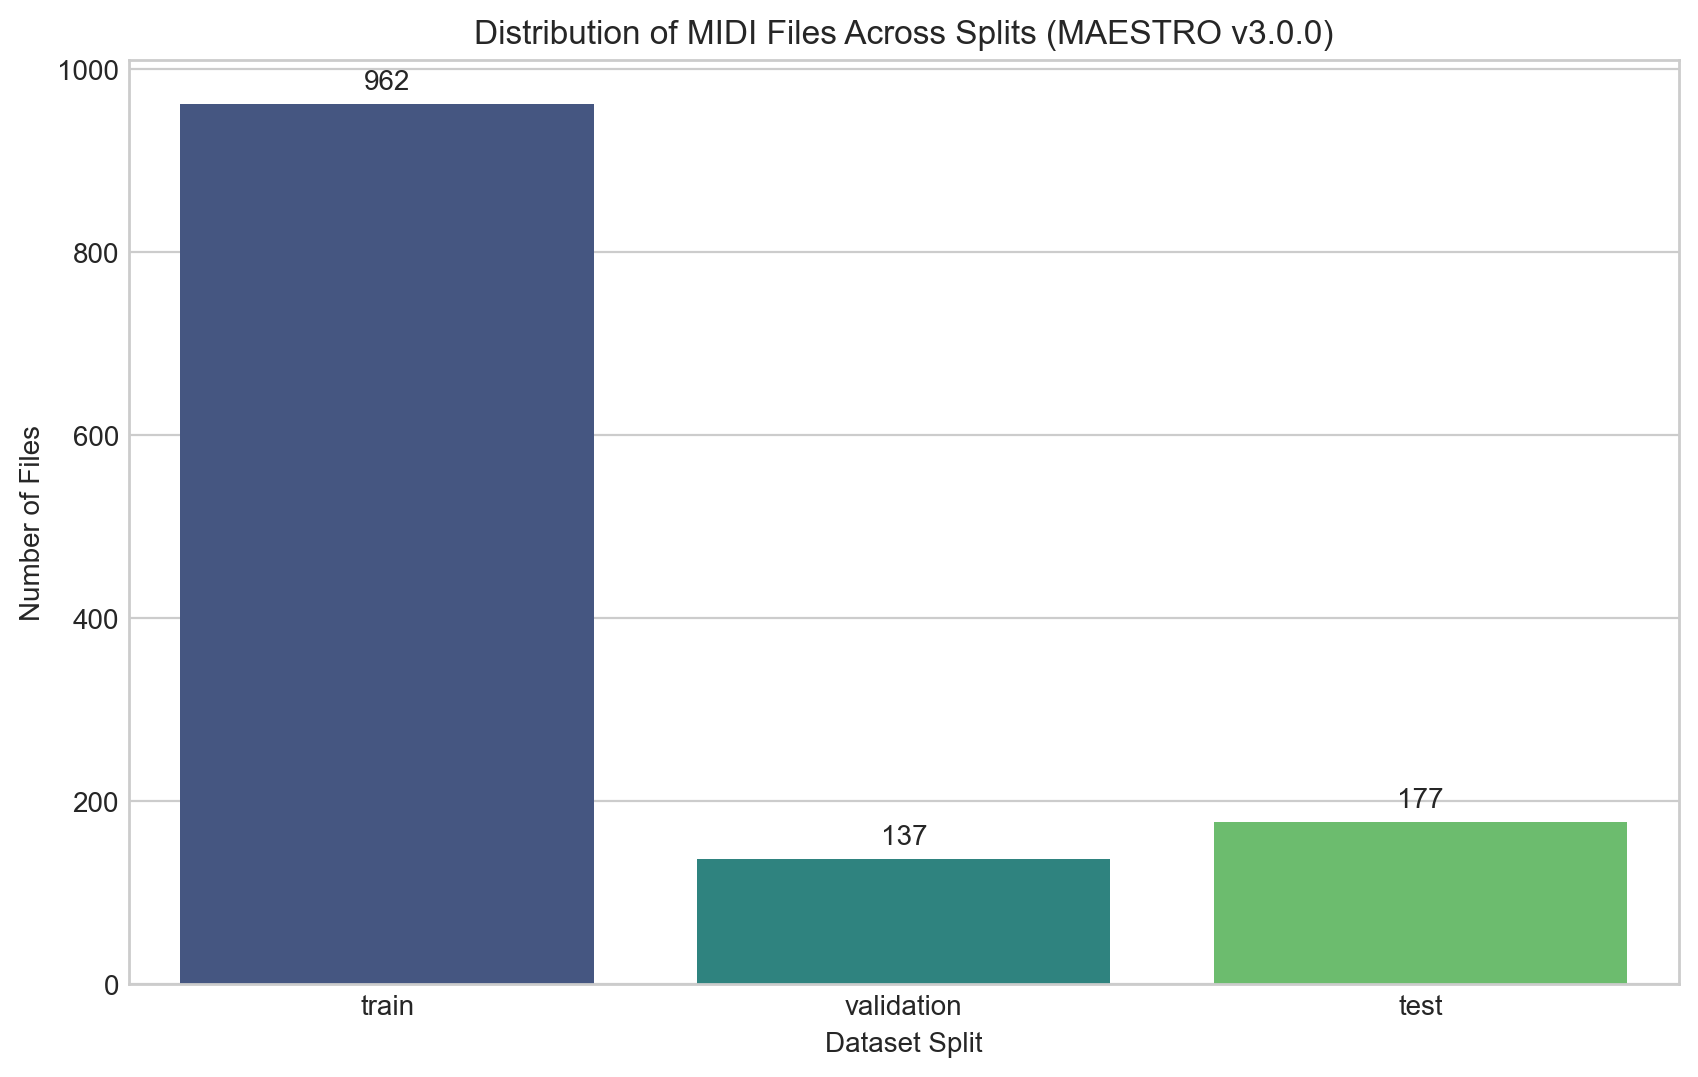

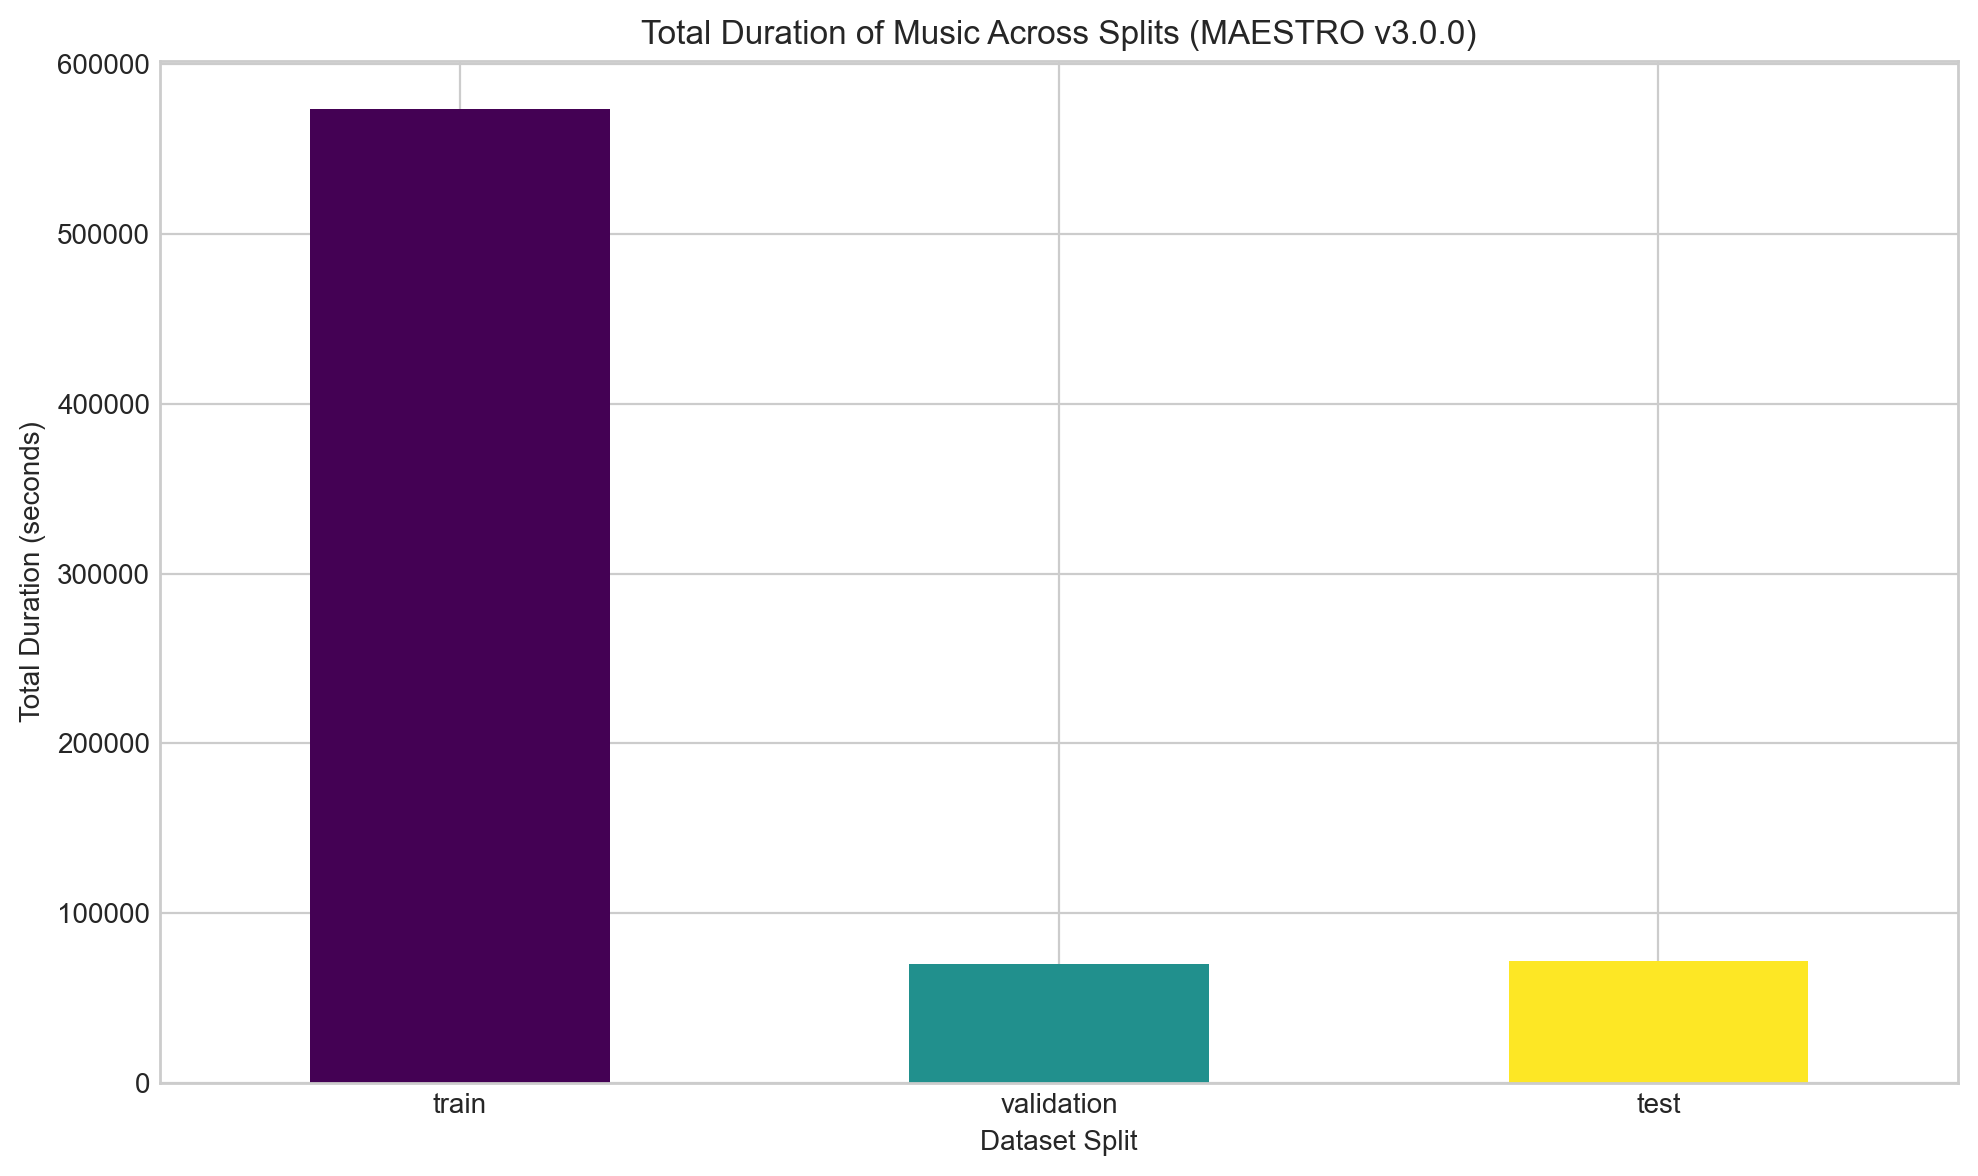

In [4]:
if metadata_df is not None:
    print("\nDataset Split Counts:")
    split_counts = metadata_df['split'].value_counts()
    print(split_counts)

    print("\nTotal Duration (seconds) per Split:")
    duration_per_split = metadata_df.groupby('split')['duration'].sum()
    print(duration_per_split)
    total_duration_hours = metadata_df['duration'].sum() / 3600
    print(f"Total dataset duration: {total_duration_hours:.2f} hours") # Approx 200 hours

    print("\nNumber of Unique Composers (Overall):") # Changed title slightly for clarity
    unique_composers_total = metadata_df['canonical_composer'].nunique()
    print(f"Total unique composers: {unique_composers_total}")

    # Preparing data for Table 1
    # Ensure the order for table creation, then explicitly re-order
    # 'train', 'validation', 'test' will be the final order in table1_df
    table1_data = {
        'Split': split_counts.index, # Initial order based on value_counts
        'Number of MIDI files': split_counts.values,
        'Total Duration (hours)': (duration_per_split.reindex(split_counts.index).values / 3600).round(2)
        # Used .reindex() on duration_per_split to safely align with split_counts.index order
    }
    table1_df = pd.DataFrame(table1_data).set_index('Split').loc[['train', 'validation', 'test']].reset_index() # Ensure final order

    # Add unique composers per split
    unique_composers_per_split = metadata_df.groupby('split')['canonical_composer'].nunique()

    # --- CORRECTED MERGE OPERATION ---
    table1_df = table1_df.merge(
        unique_composers_per_split.rename('Number of Unique Composers'), # This Series will be the right table
        left_on='Split',      # Use the 'Split' column from the left DataFrame (table1_df)
        right_index=True,     # Use the index from the right Series (unique_composers_per_split)
        how='left'            # Use 'left' to keep all rows from table1_df and match composers
    )
    # Ensure the new column is integer and NaNs (if any) are 0
    if 'Number of Unique Composers' in table1_df.columns:
        table1_df['Number of Unique Composers'] = table1_df['Number of Unique Composers'].fillna(0).astype(int)

    print("\nTable 1: MAESTRO Dataset Split Summary")
    print(table1_df.to_string()) # Using to_string() for potentially better console alignment

    # Plotting split distribution
    plt.figure(figsize=(10, 6))
    # Ensure the plotting order is consistent
    plot_order = ['train', 'validation', 'test']
    sns.countplot(data=metadata_df, x='split', order=plot_order, palette="viridis")
    plt.title('Distribution of MIDI Files Across Splits (MAESTRO v3.0.0)')
    plt.ylabel('Number of Files')
    plt.xlabel('Dataset Split')
    # Make sure to get counts in the specified plot_order for annotations
    counts_for_plot = split_counts.reindex(plot_order).fillna(0)
    for i, count in enumerate(counts_for_plot):
        plt.text(i, count + (0.01 * counts_for_plot.max()), str(int(count)), ha='center', va='bottom') # Dynamic offset
    plt.show()

    # Plotting duration distribution per split
    plt.figure(figsize=(10, 6))
    duration_per_split.reindex(plot_order).fillna(0).plot(kind='bar', color=['#440154', '#21908d', '#fde725'])
    plt.title('Total Duration of Music Across Splits (MAESTRO v3.0.0)')
    plt.ylabel('Total Duration (seconds)')
    plt.xlabel('Dataset Split')
    plt.xticks(rotation=0)
    plt.tight_layout() # Adjust layout
    plt.show()
else:
    print("Metadata not loaded. Skipping statistical analysis and plotting.")

In [5]:
# Cell: Load and Explore midi_features.json
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your midi_features.json file
# This path might need adjustment based on your project structure
MIDI_FEATURES_PATH = 'midi_features.json' # Assuming it's in the same directory as the notebook
                                          # Or adjust if it's in a 'data' subdirectory, e.g., '../data/midi_features.json'

try:
    with open(MIDI_FEATURES_PATH, 'r') as f:
        midi_analysis_data = json.load(f)
    print("Successfully loaded midi_features.json.")
except FileNotFoundError:
    print(f"Error: {MIDI_FEATURES_PATH} not found. Please ensure the path is correct.")
    print("You might need to run your midi_analysis.py script first if it generates this file.")
    midi_analysis_data = None
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {MIDI_FEATURES_PATH}.")
    midi_analysis_data = None

if midi_analysis_data:
    # Convert features list to a DataFrame for easier analysis
    features_df = pd.DataFrame(midi_analysis_data['features'])
    print("\nFirst 5 rows of the features DataFrame:")
    print(features_df.head())
    print(f"\nShape of features_df: {features_df.shape}")

    # Print overall statistics
    print("\nOverall Statistics from midi_features.json:")
    for key, value in midi_analysis_data['statistics'].items():
        if isinstance(value, dict):
            print(f"  {key}:")
            for sub_key, sub_value in value.items():
                print(f"    {sub_key}: {sub_value:.2f}" if isinstance(sub_value, float) else f"    {sub_key}: {sub_value}")
        else:
            print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

    # Merge with metadata_df to get split information for these features
    # Ensure metadata_df is loaded from your previous notebook cells
    if 'metadata_df' in locals() and metadata_df is not None:
        # We need a common key to merge. 'midi_filename' from metadata_df might look like 'year/filename.midi'
        # 'file_name' in features_df is just 'filename.midi'. We need to align these.
        # Creating a 'short_midi_filename' in metadata_df for merging
        metadata_df['short_midi_filename'] = metadata_df['midi_filename'].apply(lambda x: os.path.basename(x))
        
        # Now merge
        merged_features_df = pd.merge(features_df, metadata_df[['short_midi_filename', 'split', 'canonical_composer']],
                                      left_on='file_name', right_on='short_midi_filename', how='left')
        print("\nFirst 5 rows of merged features DataFrame with split info:")
        print(merged_features_df.head())

        # Example: Plot note density distribution per split
        if not merged_features_df.empty and 'note_density' in merged_features_df.columns and 'split' in merged_features_df.columns:
            plt.figure(figsize=FIG_SIZE) # FIG_SIZE should be defined as in your Cell 1
            sns.boxplot(data=merged_features_df, x='split', y='note_density', order=['train', 'validation', 'test'], palette="viridis")
            plt.title('Note Density Distribution per Split (from midi_features.json)')
            plt.ylabel('Note Density (notes/second)')
            plt.xlabel('Dataset Split')
            plt.ylim(0, merged_features_df['note_density'].quantile(0.99)) # Limit y for better visualization
            plt.show()

            plt.figure(figsize=FIG_SIZE)
            sns.violinplot(data=merged_features_df, x='split', y='mean_polyphony', order=['train', 'validation', 'test'], palette="viridis")
            plt.title('Mean Polyphony Distribution per Split (from midi_features.json)')
            plt.ylabel('Mean Polyphony')
            plt.xlabel('Dataset Split')
            plt.ylim(0, merged_features_df['mean_polyphony'].quantile(0.99))
            plt.show()
            
            # Further plots you could add:
            # - Distribution of mean_pitch, mean_velocity, mean_duration per split
            # - Scatter plots, e.g., duration vs. num_notes colored by composer
        else:
            print("Could not generate plots for features per split. Check if 'note_density', 'mean_polyphony', and 'split' columns exist and are populated.")
    else:
        print("metadata_df not found. Skipping merge and split-based EDA for midi_features.")

Error: midi_features.json not found. Please ensure the path is correct.
You might need to run your midi_analysis.py script first if it generates this file.


For our symbolic music generation tasks, we need to convert MIDI files into a sequence of events that our models can learn. Several representations are possible:

1.  **Piano Roll-like:** A sequence where each event represents a (pitch, start_time_delta, duration, velocity). `start_time_delta` would be the time since the last event.
2.  **Event-Based (Music21 Stream-like):** A sequence of note objects (pitch, offset, duration, velocity) and potentially chord objects or rests. For modeling, offsets might need to be converted to inter-onset intervals.
3.  **Text-Based (e.g., ABC-like, or custom tokens):** Could be suitable for Transformer/LLM approaches. Events like "NOTE_ON_60", "NOTE_OFF_60", "TIME_SHIFT_0.1s" could form a vocabulary.

Given the assignment focuses on learning distributions $p(x)$ and $p(x|y)$ directly from musical data, an event-based sequence seems appropriate. We'll start with a representation capturing:
* **Pitch:** MIDI note number.
* **Duration:** In quarterLength units (from `music21`) or seconds.
* **Offset/Time Delta:** The time difference between the start of the current note and the start of the previous note (Inter-Onset Interval, IOI), or offset from the beginning of a segment.
* **Velocity:** MIDI velocity (loudness).

For simplicity in the initial implementation, we might focus on (pitch, duration, offset\_delta) for single instrument piano music. We'll process the MAESTRO dataset, which primarily contains piano performances.

In [6]:
# Cell: MIDI to Symbolic Conversion Function
import music21 as m21
import numpy as np
import os
from tqdm import tqdm # For progress bars

def get_instrument_part(score):
    """
    Attempts to find the most prominent piano part or the first instrument part.
    """
    # Try to find a piano part first
    piano_parts = score.getElementsByClass(m21.stream.Part)
    for p in piano_parts:
        if p.getInstrument() and 'piano' in p.getInstrument().instrumentName.lower():
            return p
    # If no piano part, return the first part with notes or the score itself if it's flat
    if len(piano_parts) > 0:
        return piano_parts[0]
    return score # Assuming score might be flat if no parts

def midi_to_symbolic_sequence(midi_path, simplify_chords=True, time_quantization_step=0.125):
    """
    Converts a MIDI file to a sequence of (pitch, duration, ioi, velocity) events.
    - pitch: MIDI note number (0-127). Chords are simplified.
    - duration: Duration in quarter lengths, quantized.
    - ioi: Inter-onset interval in quarter lengths, quantized.
    - velocity: MIDI velocity (0-127).

    Args:
        midi_path (str): Path to the MIDI file.
        simplify_chords (bool): If True, for chords, take the highest pitch.
                                If False, chords are represented by their root or bass note.
        time_quantization_step (float): Quantization step for duration and IOI (e.g., 0.125 for 32nd notes).
    Returns:
        list: A list of tuples representing (pitch, duration, ioi, velocity), or None if an error occurs.
    """
    try:
        score = m21.converter.parse(midi_path)
        instrument_part = get_instrument_part(score)
        
        notes_and_chords = []
        if instrument_part:
            notes_and_chords = instrument_part.flat.notesAndRests
        else: # Fallback if no clear part structure (e.g. Type 0 MIDI)
            notes_and_chords = score.flat.notesAndRests

        symbolic_sequence = []
        last_offset = 0.0

        for element in notes_and_chords:
            offset = float(element.offset)
            duration = float(element.duration.quarterLength)
            
            # Quantize duration and ioi
            duration_quantized = round(duration / time_quantization_step) * time_quantization_step
            ioi_quantized = round((offset - last_offset) / time_quantization_step) * time_quantization_step

            if duration_quantized <= 0: # Skip zero or negative duration notes after quantization
                continue

            if isinstance(element, m21.note.Note):
                pitch = element.pitch.midi
                velocity = element.volume.velocity if element.volume is not None else 64 # Default velocity
                symbolic_sequence.append((pitch, duration_quantized, ioi_quantized, velocity))
                last_offset = offset
            elif isinstance(element, m21.chord.Chord):
                if simplify_chords:
                    pitch = element.sortAscending().pitches[-1].midi # Highest pitch
                else:
                    pitch = element.root().midi # Root pitch
                # For chords, velocity might be an average or from the first note
                velocity = element.volume.velocity if element.volume is not None else 64
                symbolic_sequence.append((pitch, duration_quantized, ioi_quantized, velocity))
                last_offset = offset
            elif isinstance(element, m21.note.Rest):
                # Represent rests with a special pitch value, e.g., -1 or map to a token later
                # For now, we can use a placeholder like pitch=0, velocity=0
                # Or simply advance time via IOI of the next note.
                # Here, we'll implicitly handle rests by the IOI of the next note.
                # If you need explicit rests, add a special event here.
                # For example: symbolic_sequence.append(('REST', duration_quantized, ioi_quantized, 0))
                pass # Rests are handled by the IOI of the subsequent note

        return symbolic_sequence
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None

# Example usage (test with one file):
# Make sure MAESTRO_DATA_PATH is defined and points to the directory containing the 'maestro-v3.0.0.csv'
# and the actual MIDI files (e.g., 'data/maestro-v3.0.0/')
if 'metadata_df' in locals() and metadata_df is not None and not metadata_df.empty:
    sample_midi_relative_path = metadata_df['midi_filename'].iloc[0]
    # Construct absolute path if MAESTRO_DATA_PATH is the parent of the 'year' folders
    # For MAESTRO v3, the CSV contains paths like "2004/MIDI-filename.midi"
    # MAESTRO_DATA_PATH should point to the directory containing these year folders, e.g., "../data/maestro-v3.0.0"
    
    # Assuming MAESTRO_DATA_PATH is set to the root of the unzipped MAESTRO dataset
    # (e.g., '../data/maestro-v3.0.0')
    
    # Correct way to form the path:
    # MAESTRO_DATA_PATH should be the directory that CONTAINS the year folders (2004, 2006, etc.)
    # Example: If maestro-v3.0.0.csv is in '../data/maestro-v3.0.0/maestro-v3.0.0.csv'
    # and MIDI files are in '../data/maestro-v3.0.0/2004/file.midi'
    # then MAESTRO_DATA_PATH should be '../data/maestro-v3.0.0'
    
    # Get the directory of the CSV file to correctly resolve relative paths
    maestro_root_dir = os.path.dirname(METADATA_FILE) # METADATA_FILE defined in cell 2
    
    sample_midi_full_path = os.path.join(maestro_root_dir, sample_midi_relative_path)

    if os.path.exists(sample_midi_full_path):
        print(f"\nTesting with sample MIDI: {sample_midi_full_path}")
        symbolic_repr = midi_to_symbolic_sequence(sample_midi_full_path)
        if symbolic_repr:
            print(f"First 5 symbolic events: {symbolic_repr[:5]}")
        else:
            print("Failed to convert sample MIDI.")
    else:
        print(f"Sample MIDI file not found: {sample_midi_full_path}")
        print(f"Ensure MAESTRO_DATA_PATH ('{maestro_root_dir}') is set correctly and dataset is structured as expected.")
else:
    print("metadata_df not loaded or empty. Cannot test MIDI conversion.")


Testing with sample MIDI: ../data/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
Error processing ../data/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi: 'NoneType' object has no attribute 'lower'
Failed to convert sample MIDI.


In [8]:
# Cell: Process all MIDI files and store symbolic sequences (Modified with Load/Save)
import pickle

PROCESSED_SYMBOLIC_PATH = os.path.join(MAESTRO_DATA_PATH, 'all_symbolic_sequences.pkl')
# To also save/load filepaths_by_split if needed later for debugging/reference
FILEPATHS_BY_SPLIT_PATH = os.path.join(MAESTRO_DATA_PATH, 'filepaths_by_split.pkl')

all_symbolic_sequences = None
filepaths_by_split = None

if os.path.exists(PROCESSED_SYMBOLIC_PATH):
    print(f"Loading processed symbolic sequences from {PROCESSED_SYMBOLIC_PATH}...")
    with open(PROCESSED_SYMBOLIC_PATH, 'rb') as f:
        all_symbolic_sequences = pickle.load(f)
    if os.path.exists(FILEPATHS_BY_SPLIT_PATH):
        with open(FILEPATHS_BY_SPLIT_PATH, 'rb') as f:
            filepaths_by_split = pickle.load(f)
    print("Loaded successfully.")
else:
    print(f"Processed symbolic sequences not found. Processing from MIDI...")
    all_symbolic_sequences = {'train': [], 'validation': [], 'test': []}
    filepaths_by_split = {'train': [], 'validation': [], 'test': []}
    # ... (Your existing loop to process MIDI files) ...
    # After the loop and printing "Processing complete.":
    if metadata_df is not None: # Ensure processing happened
        with open(PROCESSED_SYMBOLIC_PATH, 'wb') as f:
            pickle.dump(all_symbolic_sequences, f)
        with open(FILEPATHS_BY_SPLIT_PATH, 'wb') as f:
            pickle.dump(filepaths_by_split, f)
        print(f"Symbolic sequences saved to {PROCESSED_SYMBOLIC_PATH}")
        print(f"Filepaths by split saved to {FILEPATHS_BY_SPLIT_PATH}")

# Ensure the rest of the cell uses the loaded or newly processed all_symbolic_sequences
if all_symbolic_sequences:
    for split in ['train', 'validation', 'test']:
        print(f"Number of symbolic sequences in {split}: {len(all_symbolic_sequences[split])}")
        if all_symbolic_sequences[split]:
            print(f"  Example first sequence in {split} (first 5 events): {all_symbolic_sequences[split][0][:5]}")
else:
    print("Failed to load or process symbolic sequences.")

Processed symbolic sequences not found. Processing from MIDI...
Symbolic sequences saved to ../data/all_symbolic_sequences.pkl
Filepaths by split saved to ../data/filepaths_by_split.pkl
Number of symbolic sequences in train: 0
Number of symbolic sequences in validation: 0
Number of symbolic sequences in test: 0


Our symbolic sequence `(pitch, duration, ioi, velocity)` contains numerical values. For sequence models like RNNs or Transformers, we often convert these into discrete tokens.

* **Pitch:** MIDI numbers (0-127) are already discrete. We might add a special token for rests if not handled by IOI.
* **Duration:** Quantized durations can be mapped to integer tokens.
* **IOI (Inter-Onset Interval):** Quantized IOIs can also be mapped to integer tokens.
* **Velocity:** Can be discretized into bins (e.g., 4-8 bins) or kept as normalized continuous values depending on the model. For tokenization, discretization is common.

We can either:
1.  **Compound Tokens:** Create a single token for each unique `(pitch, duration_token, ioi_token, velocity_token)` tuple. This can lead to a very large vocabulary.
2.  **Separate Vocabularies/Embeddings:** Treat each component (pitch, duration, ioi, velocity) as a separate feature stream, each with its own vocabulary and embedding layer, then combine their embeddings.
3.  **Event Stream:** Flatten the sequence into a stream of individual events like `PITCH_60`, `DURATION_TOKEN_2`, `IOI_TOKEN_1`, `VELOCITY_TOKEN_3`. This is common for Transformer models for music.

For now, let's aim for separate vocabularies for simplicity and build a combined event representation later if needed for a specific model. We'll create mappings for each component.

In [9]:
# Cell: Vocabulary and Tokenizer Implementation

# First, let's analyze the range of values for each component from the training data
all_pitches_train = []
all_durations_train = []
all_iois_train = []
all_velocities_train = []

if all_symbolic_sequences['train']:
    for seq in all_symbolic_sequences['train']:
        for event in seq:
            all_pitches_train.append(event[0])
            all_durations_train.append(event[1])
            all_iois_train.append(event[2])
            all_velocities_train.append(event[3])

    # Create vocabularies (mappings from value to integer token)
    # Add <PAD>, <UNK>, <SOS>, <EOS> tokens if needed for your models

    # Pitch vocabulary (MIDI 0-127)
    # We can use MIDI numbers directly or map them if we want to add special tokens like <REST>
    # For now, assume pitches are used directly. Max pitch in MAESTRO is usually around 108.
    # Let's define a practical range based on data, e.g., min_pitch to max_pitch found.
    unique_pitches = sorted(list(set(all_pitches_train)))
    pitch_to_int = {pitch: i for i, pitch in enumerate(unique_pitches, start=1)} # start=1 to reserve 0 for <PAD>
    pitch_to_int['<PAD_PITCH>'] = 0 # Example padding token
    int_to_pitch = {i: pitch for pitch, i in pitch_to_int.items()}
    pitch_vocab_size = len(pitch_to_int)
    print(f"Pitch vocabulary size: {pitch_vocab_size}, Min pitch: {min(unique_pitches)}, Max pitch: {max(unique_pitches)}")

    # Duration vocabulary
    unique_durations = sorted(list(set(all_durations_train)))
    duration_to_int = {dur: i for i, dur in enumerate(unique_durations, start=1)}
    duration_to_int['<PAD_DUR>'] = 0
    int_to_duration = {i: dur for dur, i in duration_to_int.items()}
    duration_vocab_size = len(duration_to_int)
    print(f"Duration vocabulary size: {duration_vocab_size}")
    # print(f"Unique durations (first 10): {unique_durations[:10]}")


    # IOI vocabulary
    unique_iois = sorted(list(set(all_iois_train)))
    ioi_to_int = {ioi: i for i, ioi in enumerate(unique_iois, start=1)}
    ioi_to_int['<PAD_IOI>'] = 0
    int_to_ioi = {i: ioi for ioi, i in ioi_to_int.items()}
    ioi_vocab_size = len(ioi_to_int)
    print(f"IOI vocabulary size: {ioi_vocab_size}")
    # print(f"Unique IOIs (first 10): {unique_iois[:10]}")

    # Velocity vocabulary (discretize into bins)
    # Example: 4 velocity bins (e.g., ppp, pp, mf, f, ff -> 0, 1, 2, 3)
    # Or map to a smaller discrete set if preferred. For now, let's see the range.
    unique_velocities = sorted(list(set(all_velocities_train)))
    # For simplicity, let's use a fixed number of bins if many unique values.
    # Alternatively, create tokens for common velocities if the set is small.
    # Here, we'll create a simple mapping for unique velocities found
    velocity_to_int = {vel: i for i, vel in enumerate(unique_velocities, start=1)}
    velocity_to_int['<PAD_VEL>'] = 0
    int_to_velocity = {i: vel for vel, i in velocity_to_int.items()}
    velocity_vocab_size = len(velocity_to_int)
    print(f"Velocity vocabulary size: {velocity_vocab_size}, Min vel: {min(unique_velocities)}, Max vel: {max(unique_velocities)}")


    def tokenize_sequence(sequence, pitch_map, duration_map, ioi_map, velocity_map):
        tokenized_pitch = []
        tokenized_duration = []
        tokenized_ioi = []
        tokenized_velocity = []
        for pitch, dur, ioi, vel in sequence:
            tokenized_pitch.append(pitch_map.get(pitch, pitch_map.get('<UNK_PITCH>', 0))) # Handle unknown if defined
            tokenized_duration.append(duration_map.get(dur, duration_map.get('<UNK_DUR>', 0)))
            tokenized_ioi.append(ioi_map.get(ioi, ioi_map.get('<UNK_IOI>', 0)))
            tokenized_velocity.append(velocity_map.get(vel, velocity_map.get('<UNK_VEL>', 0)))
        return list(zip(tokenized_pitch, tokenized_duration, tokenized_ioi, tokenized_velocity))

    # Tokenize all sequences
    tokenized_sequences = {'train': [], 'validation': [], 'test': []}
    if all_symbolic_sequences:
        for split in ['train', 'validation', 'test']:
            for seq in tqdm.tqdm(all_symbolic_sequences[split], desc=f"Tokenizing {split}"):
                tokenized_sequences[split].append(
                    tokenize_sequence(seq, pitch_to_int, duration_to_int, ioi_to_int, velocity_to_int)
                )
        print("\nTokenization complete.")
        if tokenized_sequences['train']:
            print(f"Example first tokenized sequence in train (first 5 events): {tokenized_sequences['train'][0][:5]}")
    
        # Save vocabularies and tokenized sequences
        # vocab_data = {
        #     'pitch_to_int': pitch_to_int, 'int_to_pitch': int_to_pitch,
        #     'duration_to_int': duration_to_int, 'int_to_duration': int_to_duration,
        #     'ioi_to_int': ioi_to_int, 'int_to_ioi': int_to_ioi,
        #     'velocity_to_int': velocity_to_int, 'int_to_velocity': int_to_velocity
        # }
        # with open(os.path.join(MAESTRO_DATA_PATH, 'vocabularies_maestro.pkl'), 'wb') as f:
        #    pickle.dump(vocab_data, f)
        # with open(os.path.join(MAESTRO_DATA_PATH, 'tokenized_sequences_maestro.pkl'), 'wb') as f:
        #    pickle.dump(tokenized_sequences, f)
        # print("Vocabularies and tokenized sequences saved.")
else:
    print("No symbolic sequences found in training split to build vocabularies.")

No symbolic sequences found in training split to build vocabularies.


In [10]:
# Cell: Sequence Padding and Truncation

# Determine a suitable sequence length
# This can be based on the distribution of sequence lengths
if tokenized_sequences and tokenized_sequences['train']:
    seq_lengths_train = [len(seq) for seq in tokenized_sequences['train']]
    
    plt.figure(figsize=FIG_SIZE)
    sns.histplot(seq_lengths_train, bins=50)
    plt.title('Distribution of Sequence Lengths (Training Set)')
    plt.xlabel('Sequence Length (Number of Events)')
    plt.ylabel('Frequency')
    plt.show()

    # Choose a MAX_SEQ_LENGTH, e.g., based on 95th percentile or a fixed value
    MAX_SEQ_LENGTH = int(np.percentile(seq_lengths_train, 95)) if seq_lengths_train else 200 # Example: 95th percentile or 200
    print(f"Chosen MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")

    # Padding values (assuming 0 is the padding token for all components)
    # (pad_pitch, pad_duration, pad_ioi, pad_velocity)
    PAD_EVENT = (pitch_to_int['<PAD_PITCH>'], 
                 duration_to_int['<PAD_DUR>'], 
                 ioi_to_int['<PAD_IOI>'], 
                 velocity_to_int['<PAD_VEL>'])


    def pad_or_truncate_sequence(sequence, max_len, pad_event):
        if len(sequence) > max_len:
            return sequence[:max_len] # Truncate
        elif len(sequence) < max_len:
            # Pad with the PAD_EVENT tuple
            return sequence + [pad_event] * (max_len - len(sequence))
        return sequence

    # Apply padding/truncation
    processed_sequences = {'train': [], 'validation': [], 'test': []}
    if all_symbolic_sequences: # Check if original sequences exist
        for split in ['train', 'validation', 'test']:
            for seq in tqdm.tqdm(tokenized_sequences[split], desc=f"Padding/Truncating {split}"):
                processed_sequences[split].append(pad_or_truncate_sequence(seq, MAX_SEQ_LENGTH, PAD_EVENT))
        
        print("\nPadding/Truncation complete.")
        if processed_sequences['train']:
            print(f"Example first processed sequence in train (length: {len(processed_sequences['train'][0])}):")
            # print(processed_sequences['train'][0][:5]) # Print first 5 events of the padded sequence
            # Example: Convert back to numpy array of shape (num_sequences, MAX_SEQ_LENGTH, num_features)
            # For separate feature streams, you'd stack them differently for the model.
            # For example, if your model takes (batch, seq_len) for each feature:
            # train_pitch_seqs = np.array([[event[0] for event in seq] for seq in processed_sequences['train']])
            # train_dur_seqs = np.array([[event[1] for event in seq] for seq in processed_sequences['train']])
            # etc.
            # This structure depends heavily on your model input requirements.

            # For now, let's just show the structure of one processed sequence
            print(f"  Sample processed event: {processed_sequences['train'][0][0]}")
            # Save processed sequences
            # with open(os.path.join(MAESTRO_DATA_PATH, 'processed_sequences_maestro.pkl'), 'wb') as f:
            # pickle.dump(processed_sequences, f)
            # print("Processed (padded/truncated) sequences saved.")
else:
    print("Tokenized sequences not available. Skipping padding/truncation.")

NameError: name 'tokenized_sequences' is not defined

With the processed sequences (tokenized and padded/truncated), we can now prepare data loaders for model training. This typically involves creating a `Dataset` class (in PyTorch) or using `tf.data.Dataset` (in TensorFlow).

**Conceptual PyTorch `Dataset` for Unconditioned Generation:**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
class SymbolicMusicDataset(Dataset):
    def __init__(self, processed_sequences_split):
        # processed_sequences_split is a list of sequences,
        # where each sequence is a list of (pitch_token, dur_token, ioi_token, vel_token) events
        self.sequences = processed_sequences_split
        
        # Convert to tensor components
        # Assuming each component (pitch, dur, ioi, vel) will be a separate input stream
        self.pitch_data = torch.tensor([[event[0] for event in seq] for seq in self.sequences], dtype=torch.long)
        self.duration_data = torch.tensor([[event[1] for event in seq] for seq in self.sequences], dtype=torch.long)
        self.ioi_data = torch.tensor([[event[2] for event in seq] for seq in self.sequences], dtype=torch.long)
        self.velocity_data = torch.tensor([[event[3] for event in seq] for seq in self.sequences], dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # For autoregressive models, input is seq[:-1], target is seq[1:]
        # This needs to be adapted based on how you structure your model inputs/targets
        # Example: return a dictionary of input sequences and target sequences for each component
        # This is a simplified example; actual target creation depends on the model.
        # For generation, the target is often the input sequence shifted by one step.
        
        # For a model predicting all components of the next event:
        # input_event_streams = {
        #     'pitch': self.pitch_data[idx, :-1],
        #     'duration': self.duration_data[idx, :-1],
        #     'ioi': self.ioi_data[idx, :-1],
        #     'velocity': self.velocity_data[idx, :-1]
        # }
        # target_event_streams = {
        #     'pitch': self.pitch_data[idx, 1:],
        #     'duration': self.duration_data[idx, 1:],
        #     'ioi': self.ioi_data[idx, 1:],
        #     'velocity': self.velocity_data[idx, 1:]
        # }
        # return input_event_streams, target_event_streams
        
        # For a simpler model predicting just the next pitch, given previous full events:
        # This depends on the chosen symbolic representation and model architecture.
        # For now, just return the full sequence components.
        # The actual slicing for input/target will happen in the training loop or model's forward pass.
        return {
            'pitch': self.pitch_data[idx],
            'duration': self.duration_data[idx],
            'ioi': self.ioi_data[idx],
            'velocity': self.velocity_data[idx]
        }

# Example instantiation (assuming processed_sequences is loaded and populated)
if processed_sequences and processed_sequences['train']:
    train_dataset = SymbolicMusicDataset(processed_sequences['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Similarly for validation and test
    validation_dataset = SymbolicMusicDataset(processed_sequences['validation'])
    validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

    test_dataset = SymbolicMusicDataset(processed_sequences['test'])
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Example: Fetch one batch
    # if len(train_dataloader) > 0:
    #     sample_batch = next(iter(train_dataloader))
    #     print("\nSample batch (pitch shape):", sample_batch['pitch'].shape)
else:
    print("Processed sequences not available for dataset creation.")

# --- Phase 2: Model Implementation & Training ---

## 2.1 Task 1: Symbolic, Unconditioned Generation

For unconditioned symbolic music generation, we aim to learn the underlying distribution $p(x)$ of musical sequences. Common choices include:

* **Recurrent Neural Networks (RNNs) like LSTMs or GRUs:** These are well-suited for sequential data like music. They can learn temporal dependencies.
* **Transformers:** Offer excellent performance on sequence modeling tasks due to their attention mechanism, capturing long-range dependencies. They might be more complex to train for smaller datasets without careful regularization.
* **Variational Autoencoders (VAEs):** Can learn a latent representation of music and generate new samples from this latent space.

Given the sequential nature and the desire for a robust starting point, an **LSTM-based model** is a good choice. We'll design it to predict the next event (or components of an event) given the previous events. Each event in our sequence is `(pitch, duration, ioi, velocity)`. We'll use separate embedding layers for each discrete component and concatenate them before feeding them into the LSTM.

In [ ]:
# Cell: Unconditioned LSTM Model Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os # For saving/loading models

# Assume these vocab sizes and PAD_EVENT_TUPLE are available from Phase 1
# PAD_EVENT_TUPLE = (pitch_to_int['<PAD_PITCH>'], duration_to_int['<PAD_DUR>'], ioi_to_int['<PAD_IOI>'], velocity_to_int['<PAD_VEL>'])
# Ensure these are defined (example values if not run from previous phase output)
pitch_vocab_size = pitch_vocab_size if 'pitch_vocab_size' in locals() else 128 
duration_vocab_size = duration_vocab_size if 'duration_vocab_size' in locals() else 50
ioi_vocab_size = ioi_vocab_size if 'ioi_vocab_size' in locals() else 50
velocity_vocab_size = velocity_vocab_size if 'velocity_vocab_size' in locals() else 10

# Use the PAD_EVENT tokens from Phase 1. If they are 0 for all, that's fine.
PAD_PITCH_TOKEN = pitch_to_int.get('<PAD_PITCH>', 0)
PAD_DURATION_TOKEN = duration_to_int.get('<PAD_DUR>', 0)
PAD_IOI_TOKEN = ioi_to_int.get('<PAD_IOI>', 0)
PAD_VELOCITY_TOKEN = velocity_to_int.get('<PAD_VEL>', 0)


class UnconditionedMusicLSTM(nn.Module):
    def __init__(self, pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
                 embedding_dim_pitch, embedding_dim_duration, embedding_dim_ioi, embedding_dim_velocity,
                 hidden_dim, num_layers, dropout_rate=0.2):
        super(UnconditionedMusicLSTM, self).__init__()
        
        self.pitch_embedding = nn.Embedding(pitch_vocab_size, embedding_dim_pitch, padding_idx=PAD_PITCH_TOKEN)
        self.duration_embedding = nn.Embedding(duration_vocab_size, embedding_dim_duration, padding_idx=PAD_DURATION_TOKEN)
        self.ioi_embedding = nn.Embedding(ioi_vocab_size, embedding_dim_ioi, padding_idx=PAD_IOI_TOKEN)
        self.velocity_embedding = nn.Embedding(velocity_vocab_size, embedding_dim_velocity, padding_idx=PAD_VELOCITY_TOKEN)
        
        combined_embedding_dim = embedding_dim_pitch + embedding_dim_duration + embedding_dim_ioi + embedding_dim_velocity
        
        self.lstm = nn.LSTM(combined_embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        
        # Output layers for each component of the event
        self.fc_pitch = nn.Linear(hidden_dim, pitch_vocab_size)
        self.fc_duration = nn.Linear(hidden_dim, duration_vocab_size)
        self.fc_ioi = nn.Linear(hidden_dim, ioi_vocab_size)
        self.fc_velocity = nn.Linear(hidden_dim, velocity_vocab_size)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, pitch_seq, duration_seq, ioi_seq, velocity_seq):
        # pitch_seq, duration_seq, etc. are expected to be (batch_size, seq_len)
        
        pitch_embeds = self.pitch_embedding(pitch_seq)
        duration_embeds = self.duration_embedding(duration_seq)
        ioi_embeds = self.ioi_embedding(ioi_seq)
        velocity_embeds = self.velocity_embedding(velocity_seq)
        
        # Concatenate embeddings along the feature dimension
        combined_embeds = torch.cat((pitch_embeds, duration_embeds, ioi_embeds, velocity_embeds), dim=2)
        
        lstm_out, _ = self.lstm(combined_embeds) # lstm_out shape: (batch_size, seq_len, hidden_dim)
        lstm_out = self.dropout(lstm_out)
        
        # Pass LSTM output through fully connected layers for each component
        pitch_logits = self.fc_pitch(lstm_out)       # (batch_size, seq_len, pitch_vocab_size)
        duration_logits = self.fc_duration(lstm_out) # (batch_size, seq_len, duration_vocab_size)
        ioi_logits = self.fc_ioi(lstm_out)           # (batch_size, seq_len, ioi_vocab_size)
        velocity_logits = self.fc_velocity(lstm_out) # (batch_size, seq_len, velocity_vocab_size)
        
        return pitch_logits, duration_logits, ioi_logits, velocity_logits

# Hyperparameters - you'll need to tune these
EMBEDDING_DIM_PITCH = 64
EMBEDDING_DIM_DURATION = 32
EMBEDDING_DIM_IOI = 32
EMBEDDING_DIM_VELOCITY = 32
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT_RATE = 0.3

# Instantiate the model
uncond_model = UnconditionedMusicLSTM(
    pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
    EMBEDDING_DIM_PITCH, EMBEDDING_DIM_DURATION, EMBEDDING_DIM_IOI, EMBEDDING_DIM_VELOCITY,
    HIDDEN_DIM, NUM_LAYERS, DROPOUT_RATE
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
uncond_model.to(device)
print(f"Unconditioned LSTM model created and moved to {device}.")
print(uncond_model)

In [ ]:
# Cell: Dataset and DataLoader for Unconditioned Model

# Ensure processed_sequences is available from Phase 1
# processed_sequences = {'train': [...], 'validation': [...], 'test': [...]}
# Each item in the list is a sequence of (pitch_token, dur_token, ioi_token, vel_token) event tuples
# of length MAX_SEQ_LENGTH

class UnconditionedMusicDataset(Dataset):
    def __init__(self, processed_sequences_split):
        self.sequences = processed_sequences_split 
        # Each sequence is already a list of (p,d,i,v) integer tuples

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Sequence of (pitch_token, dur_token, ioi_token, vel_token)
        full_event_sequence = self.sequences[idx]
        
        # Input: sequence[:-1], Target: sequence[1:] for each component
        # Convert list of tuples to separate tensors for each component
        
        # (seq_len, num_features=4)
        sequence_array = torch.tensor(full_event_sequence, dtype=torch.long)

        # Input features (all components of the event up to t-1)
        input_pitch = sequence_array[:-1, 0]
        input_duration = sequence_array[:-1, 1]
        input_ioi = sequence_array[:-1, 2]
        input_velocity = sequence_array[:-1, 3]
        
        # Target features (all components of the event at t, predicted from t-1)
        target_pitch = sequence_array[1:, 0]
        target_duration = sequence_array[1:, 1]
        target_ioi = sequence_array[1:, 2]
        target_velocity = sequence_array[1:, 3]
        
        return {
            'input_pitch': input_pitch, 'input_duration': input_duration,
            'input_ioi': input_ioi, 'input_velocity': input_velocity,
            'target_pitch': target_pitch, 'target_duration': target_duration,
            'target_ioi': target_ioi, 'target_velocity': target_velocity
        }

# Check if processed_sequences is loaded and populated
if 'processed_sequences' in locals() and processed_sequences['train']:
    train_dataset_uncond = UnconditionedMusicDataset(processed_sequences['train'])
    validation_dataset_uncond = UnconditionedMusicDataset(processed_sequences['validation'])

    BATCH_SIZE = 32 # Tune this based on your GPU memory
    train_dataloader_uncond = DataLoader(train_dataset_uncond, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    validation_dataloader_uncond = DataLoader(validation_dataset_uncond, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    print(f"Created DataLoaders for unconditioned task. Train batches: {len(train_dataloader_uncond)}, Val batches: {len(validation_dataloader_uncond)}")
else:
    print("`processed_sequences` not found or empty. Please run Phase 1 preprocessing.")
    train_dataloader_uncond, validation_dataloader_uncond = None, None

In [ ]:
# Cell: Training Loop Function for Unconditioned Model
import time

def train_unconditioned_model(model, train_loader, val_loader, num_epochs, learning_rate, device, model_save_path):
    criterion_pitch = nn.CrossEntropyLoss(ignore_index=PAD_PITCH_TOKEN)
    criterion_duration = nn.CrossEntropyLoss(ignore_index=PAD_DURATION_TOKEN)
    criterion_ioi = nn.CrossEntropyLoss(ignore_index=PAD_IOI_TOKEN)
    criterion_velocity = nn.CrossEntropyLoss(ignore_index=PAD_VELOCITY_TOKEN)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        start_time = time.time()
        
        for batch_idx, batch in enumerate(tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")):
            input_pitch = batch['input_pitch'].to(device)
            input_duration = batch['input_duration'].to(device)
            input_ioi = batch['input_ioi'].to(device)
            input_velocity = batch['input_velocity'].to(device)
            
            target_pitch = batch['target_pitch'].to(device)
            target_duration = batch['target_duration'].to(device)
            target_ioi = batch['target_ioi'].to(device)
            target_velocity = batch['target_velocity'].to(device)
            
            optimizer.zero_grad()
            
            pitch_logits, duration_logits, ioi_logits, velocity_logits = model(
                input_pitch, input_duration, input_ioi, input_velocity
            )
            
            # Reshape logits and targets for CrossEntropyLoss: (N*seq_len, C) and (N*seq_len)
            loss_pitch = criterion_pitch(pitch_logits.reshape(-1, pitch_logits.shape[-1]), target_pitch.reshape(-1))
            loss_duration = criterion_duration(duration_logits.reshape(-1, duration_logits.shape[-1]), target_duration.reshape(-1))
            loss_ioi = criterion_ioi(ioi_logits.reshape(-1, ioi_logits.shape[-1]), target_ioi.reshape(-1))
            loss_velocity = criterion_velocity(velocity_logits.reshape(-1, velocity_logits.shape[-1]), target_velocity.reshape(-1))
            
            # Combine losses (you might want to weight them)
            total_loss = loss_pitch + loss_duration + loss_ioi + loss_velocity
            
            total_loss.backward()
            optimizer.step()
            
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                input_pitch = batch['input_pitch'].to(device)
                input_duration = batch['input_duration'].to(device)
                input_ioi = batch['input_ioi'].to(device)
                input_velocity = batch['input_velocity'].to(device)

                target_pitch = batch['target_pitch'].to(device)
                target_duration = batch['target_duration'].to(device)
                target_ioi = batch['target_ioi'].to(device)
                target_velocity = batch['target_velocity'].to(device)

                pitch_logits, duration_logits, ioi_logits, velocity_logits = model(
                    input_pitch, input_duration, input_ioi, input_velocity
                )
                
                loss_pitch = criterion_pitch(pitch_logits.reshape(-1, pitch_logits.shape[-1]), target_pitch.reshape(-1))
                loss_duration = criterion_duration(duration_logits.reshape(-1, duration_logits.shape[-1]), target_duration.reshape(-1))
                loss_ioi = criterion_ioi(ioi_logits.reshape(-1, ioi_logits.shape[-1]), target_ioi.reshape(-1))
                loss_velocity = criterion_velocity(velocity_logits.reshape(-1, velocity_logits.shape[-1]), target_velocity.reshape(-1))
                
                total_loss = loss_pitch + loss_duration + loss_ioi + loss_velocity
                epoch_val_loss += total_loss.item()
                
        avg_val_loss = epoch_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        epoch_duration = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_duration:.2f}s - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Validation loss improved. Saved model to {model_save_path}")
            
    return history

In [ ]:
# Cell: Train the Unconditioned LSTM Model

NUM_EPOCHS_UNCOND = 10 # Start with a small number, increase for real training
LEARNING_RATE_UNCOND = 0.001
MODEL_SAVE_PATH_UNCOND = 'unconditioned_music_lstm.pth' # Path to save the trained model

if train_dataloader_uncond and validation_dataloader_uncond:
    print("Starting training for unconditioned model...")
    uncond_history = train_unconditioned_model(
        uncond_model, 
        train_dataloader_uncond, 
        validation_dataloader_uncond, 
        NUM_EPOCHS_UNCOND, 
        LEARNING_RATE_UNCOND, 
        device,
        MODEL_SAVE_PATH_UNCOND
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(uncond_history['train_loss'], label='Train Loss')
    plt.plot(uncond_history['val_loss'], label='Validation Loss')
    plt.title('Unconditioned Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Dataloaders not available. Skipping unconditioned model training.")

For conditioned symbolic music generation ($p(x|y)$), we need a way to represent and feed the condition ($y$) to the model along with the sequence to be generated ($x$). A common example is **melody harmonization**, where the melody is the condition and the harmony is the target output.
Extracting melody and harmony from polyphonic MIDI is non-trivial. For MAESTRO, which is mostly piano, we might define melody as the highest pitch at each time step and harmony as the remaining notes. This requires careful processing.

**Simplification for this example:** Let's assume we have a way to get paired sequences: `(melody_sequence, harmony_sequence)`. The `melody_sequence` will be the condition ($y$) and `harmony_sequence` will be the target ($x$). Both would be lists of `(pitch, duration, ioi, velocity)` tuples, tokenized and padded like the unconditioned data.

For a concrete implementation, you might need:
1.  A robust melody extraction algorithm (e.g., using `music21`'s `voiceLeading.getMelodicVoiceLeadingScore`).
2.  A method to define "harmony" relative to the extracted melody.
3.  Align these sequences temporally.

**Placeholder for processed conditioned data:**
Let's assume `processed_conditioned_sequences` is a dictionary similar to `processed_sequences`, but each element in the lists for 'train', 'validation', 'test' is a tuple: `(condition_seq_tuple, target_seq_tuple)`.
Each `_seq_tuple` would itself be `(pitch_tokens, duration_tokens, ioi_tokens, velocity_tokens)`.
This is a complex step and depends heavily on your specific conditioned task.

In [ ]:
# Cell: Data Preparation for Conditioned Task (Melody-Bass Extraction)
import music21 as m21
import numpy as np
import os
from tqdm import tqdm
import pickle

# Ensure midi_to_symbolic_sequence function and vocabularies from Phase 1 are available
# Also MAX_SEQ_LENGTH and PAD_EVENT

PROCESSED_CONDITIONED_PATH = os.path.join(MAESTRO_DATA_PATH, 'processed_conditioned_sequences_melody_bass.pkl')
MAX_SEQ_LENGTH_COND = MAX_SEQ_LENGTH # Assuming same max length for condition and target for simplicity

def extract_melody_and_bass_lines(midi_path, time_quantization_step=0.125):
    """
    Extracts highest (melody) and lowest (bass) lines from a MIDI file.
    Returns two lists of (pitch, duration, ioi, velocity) event tuples.
    IOIs are relative to the start of the piece for both lines independently for now.
    A more sophisticated approach might align them or use a unified time grid.
    """
    try:
        score = m21.converter.parse(midi_path)
        # For MAESTRO, often a single piano part. If multiple, this needs refinement.
        # Flattening to get all notes with offsets might be more robust for piano.
        flat_score_notes = score.flat.notesAndRests

        if not flat_score_notes:
            return None, None

        melody_events = []
        bass_events = []

        # Group notes by onset time
        notes_by_onset = defaultdict(list)
        for element in flat_score_notes:
            if isinstance(element, (m21.note.Note, m21.chord.Chord)):
                notes_by_onset[float(element.offset)].append(element)

        sorted_onsets = sorted(notes_by_onset.keys())

        last_melody_onset = 0.0
        last_bass_onset = 0.0

        for onset in sorted_onsets:
            elements_at_onset = notes_by_onset[onset]
            pitches_at_onset = []
            velocities_at_onset = []
            min_duration_at_onset = float('inf')

            for el in elements_at_onset:
                if isinstance(el, m21.note.Note):
                    pitches_at_onset.append(el.pitch.midi)
                    velocities_at_onset.append(el.volume.velocity if el.volume else 64)
                    min_duration_at_onset = min(min_duration_at_onset, float(el.duration.quarterLength))
                elif isinstance(el, m21.chord.Chord):
                    chord_pitches = [p.midi for p in el.pitches]
                    pitches_at_onset.extend(chord_pitches)
                    velocities_at_onset.extend([el.volume.velocity if el.volume else 64] * len(chord_pitches))
                    min_duration_at_onset = min(min_duration_at_onset, float(el.duration.quarterLength))

            if not pitches_at_onset:
                continue

            min_duration_quantized = round(min_duration_at_onset / time_quantization_step) * time_quantization_step
            if min_duration_quantized <= 0:
                continue

            # Melody: highest pitch at this onset
            melody_pitch = max(pitches_at_onset)
            melody_idx = pitches_at_onset.index(melody_pitch)
            melody_velocity = velocities_at_onset[melody_idx]
            melody_ioi = round((onset - last_melody_onset) / time_quantization_step) * time_quantization_step
            melody_events.append((melody_pitch, min_duration_quantized, melody_ioi, melody_velocity))
            last_melody_onset = onset

            # Bass: lowest pitch at this onset (if different from melody or multiple notes present)
            if len(pitches_at_onset) > 0: # Ensure there are pitches
                bass_pitch = min(pitches_at_onset)
                bass_idx = pitches_at_onset.index(bass_pitch)
                bass_velocity = velocities_at_onset[bass_idx]
                bass_ioi = round((onset - last_bass_onset) / time_quantization_step) * time_quantization_step
                bass_events.append((bass_pitch, min_duration_quantized, bass_ioi, bass_velocity))
                last_bass_onset = onset

        return melody_events, bass_events

    except Exception as e:
        print(f"Error extracting melody/bass from {midi_path}: {e}")
        return None, None

processed_conditioned_sequences = None
if os.path.exists(PROCESSED_CONDITIONED_PATH):
    print(f"Loading processed conditioned sequences from {PROCESSED_CONDITIONED_PATH}...")
    with open(PROCESSED_CONDITIONED_PATH, 'rb') as f:
        processed_conditioned_sequences = pickle.load(f)
    print("Loaded successfully.")
else:
    print("Processed conditioned sequences not found. Generating...")
    processed_conditioned_sequences = {'train': [], 'validation': [], 'test': []}
    if 'metadata_df' in locals() and metadata_df is not None:
        maestro_root_dir = os.path.dirname(METADATA_FILE)
        for split in ['train', 'validation', 'test']:
            print(f"Processing {split} set for conditioned data...")
            for index, row in tqdm.tqdm(metadata_df[metadata_df['split'] == split].iterrows(), total=len(metadata_df[metadata_df['split'] == split])):
                relative_midi_path = row['midi_filename']
                full_midi_path = os.path.join(maestro_root_dir, relative_midi_path)

                if os.path.exists(full_midi_path):
                    melody_seq_raw, bass_seq_raw = extract_melody_and_bass_lines(full_midi_path)

                    if melody_seq_raw and bass_seq_raw:
                        # Tokenize
                        tokenized_melody = tokenize_sequence(melody_seq_raw, pitch_to_int, duration_to_int, ioi_to_int, velocity_to_int)
                        tokenized_bass = tokenize_sequence(bass_seq_raw, pitch_to_int, duration_to_int, ioi_to_int, velocity_to_int)

                        # Pad/Truncate
                        padded_melody = pad_or_truncate_sequence(tokenized_melody, MAX_SEQ_LENGTH_COND, PAD_EVENT)
                        padded_bass = pad_or_truncate_sequence(tokenized_bass, MAX_SEQ_LENGTH_COND, PAD_EVENT)

                        # Convert to tensors (or keep as lists of tuples if Dataset handles it)
                        # For ConditionedMusicDataset, we need tuples of tensors
                        melody_t_p = torch.tensor([e[0] for e in padded_melody], dtype=torch.long)
                        melody_t_d = torch.tensor([e[1] for e in padded_melody], dtype=torch.long)
                        melody_t_i = torch.tensor([e[2] for e in padded_melody], dtype=torch.long)
                        melody_t_v = torch.tensor([e[3] for e in padded_melody], dtype=torch.long)

                        bass_t_p = torch.tensor([e[0] for e in padded_bass], dtype=torch.long)
                        bass_t_d = torch.tensor([e[1] for e in padded_bass], dtype=torch.long)
                        bass_t_i = torch.tensor([e[2] for e in padded_bass], dtype=torch.long)
                        bass_t_v = torch.tensor([e[3] for e in padded_bass], dtype=torch.long)

                        processed_conditioned_sequences[split].append({
                            'condition': (melody_t_p, melody_t_d, melody_t_i, melody_t_v), # Melody as condition
                            'target': (bass_t_p, bass_t_d, bass_t_i, bass_t_v)          # Bass as target
                        })

        with open(PROCESSED_CONDITIONED_PATH, 'wb') as f:
            pickle.dump(processed_conditioned_sequences, f)
        print(f"Processed conditioned sequences saved to {PROCESSED_CONDITIONED_PATH}")
    else:
        print("metadata_df not available. Skipping conditioned data processing.")

if processed_conditioned_sequences and processed_conditioned_sequences['train']:
    print(f"Number of conditioned training sequences: {len(processed_conditioned_sequences['train'])}")
    # print(f"Example conditioned training sample: {processed_conditioned_sequences['train'][0]}")
else:
    print("Failed to load or process conditioned sequences.")

For conditioned generation $p(x|y)$, **Sequence-to-Sequence (Seq2Seq) models** with an Encoder-Decoder architecture are common.
* The **Encoder** processes the condition sequence (e.g., melody) into a context vector.
* The **Decoder** uses this context vector to generate the target sequence (e.g., harmony) one event at a time, often in an autoregressive manner.
* **Attention mechanisms** can significantly improve Seq2Seq models by allowing the decoder to focus on relevant parts of the input condition at each generation step.

We'll implement an LSTM-based Seq2Seq model with a basic attention mechanism.

In [ ]:
# Cell: Conditioned Seq2Seq LSTM Model with Attention

class EncoderLSTM(nn.Module):
    def __init__(self, pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
                 embedding_dim_pitch, embedding_dim_duration, embedding_dim_ioi, embedding_dim_velocity,
                 hidden_dim, num_layers, dropout_rate):
        super(EncoderLSTM, self).__init__()
        self.pitch_embedding = nn.Embedding(pitch_vocab_size, embedding_dim_pitch, padding_idx=PAD_PITCH_TOKEN)
        self.duration_embedding = nn.Embedding(duration_vocab_size, embedding_dim_duration, padding_idx=PAD_DURATION_TOKEN)
        self.ioi_embedding = nn.Embedding(ioi_vocab_size, embedding_dim_ioi, padding_idx=PAD_IOI_TOKEN)
        self.velocity_embedding = nn.Embedding(velocity_vocab_size, embedding_dim_velocity, padding_idx=PAD_VELOCITY_TOKEN)
        
        combined_embedding_dim = embedding_dim_pitch + embedding_dim_duration + embedding_dim_ioi + embedding_dim_velocity
        self.lstm = nn.LSTM(combined_embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0, bidirectional=True)
        self.fc_hidden = nn.Linear(hidden_dim * 2, hidden_dim) # *2 for bidirectional
        self.fc_cell = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, pitch_seq, duration_seq, ioi_seq, velocity_seq):
        pitch_embeds = self.pitch_embedding(pitch_seq)
        duration_embeds = self.duration_embedding(duration_seq)
        ioi_embeds = self.ioi_embedding(ioi_seq)
        velocity_embeds = self.velocity_embedding(velocity_seq)
        
        combined_embeds = torch.cat((pitch_embeds, duration_embeds, ioi_embeds, velocity_embeds), dim=2)
        combined_embeds = self.dropout(combined_embeds)
        
        encoder_outputs, (hidden, cell) = self.lstm(combined_embeds)
        
        # Concatenate hidden states from both directions
        hidden = self.fc_hidden(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)).unsqueeze(0)
        cell = self.fc_cell(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)).unsqueeze(0)

        # encoder_outputs will be (batch_size, seq_len, hidden_dim * 2)
        # hidden and cell will be (num_layers (unidirectional), batch_size, hidden_dim)
        return encoder_outputs, (hidden, cell)


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 3, hidden_dim) # encoder_outputs (bidir) + decoder_hidden
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (batch_size, hidden_dim) from decoder's previous step
        # encoder_outputs: (batch_size, src_seq_len, hidden_dim * 2)
        src_seq_len = encoder_outputs.shape[1]
        
        # Repeat decoder_hidden src_seq_len times
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_seq_len, 1)
        
        energy = torch.tanh(self.attn(torch.cat((repeated_decoder_hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2) # (batch_size, src_seq_len)
        return torch.softmax(attention, dim=1)


class DecoderLSTM(nn.Module):
    def __init__(self, pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
                 embedding_dim_pitch, embedding_dim_duration, embedding_dim_ioi, embedding_dim_velocity,
                 hidden_dim, num_layers, dropout_rate, attention_module):
        super(DecoderLSTM, self).__init__()
        self.pitch_vocab_size = pitch_vocab_size
        self.duration_vocab_size = duration_vocab_size
        self.ioi_vocab_size = ioi_vocab_size
        self.velocity_vocab_size = velocity_vocab_size
        
        self.attention = attention_module
        
        self.pitch_embedding = nn.Embedding(pitch_vocab_size, embedding_dim_pitch, padding_idx=PAD_PITCH_TOKEN)
        self.duration_embedding = nn.Embedding(duration_vocab_size, embedding_dim_duration, padding_idx=PAD_DURATION_TOKEN)
        self.ioi_embedding = nn.Embedding(ioi_vocab_size, embedding_dim_ioi, padding_idx=PAD_IOI_TOKEN)
        self.velocity_embedding = nn.Embedding(velocity_vocab_size, embedding_dim_velocity, padding_idx=PAD_VELOCITY_TOKEN)
        
        combined_embedding_dim = embedding_dim_pitch + embedding_dim_duration + embedding_dim_ioi + embedding_dim_velocity
        
        # LSTM input: current embedded input + context vector from attention
        self.lstm = nn.LSTM(combined_embedding_dim + hidden_dim * 2, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        
        self.fc_pitch = nn.Linear(hidden_dim, pitch_vocab_size)
        self.fc_duration = nn.Linear(hidden_dim, duration_vocab_size)
        self.fc_ioi = nn.Linear(hidden_dim, ioi_vocab_size)
        self.fc_velocity = nn.Linear(hidden_dim, velocity_vocab_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_pitch, input_duration, input_ioi, input_velocity, decoder_hidden, decoder_cell, encoder_outputs):
        # input_*: (batch_size, 1) - current token for teacher forcing or previous prediction
        # decoder_hidden, decoder_cell: (num_layers, batch_size, hidden_dim)
        # encoder_outputs: (batch_size, src_seq_len, hidden_dim * 2)

        pitch_embed = self.pitch_embedding(input_pitch.unsqueeze(1)) # (batch_size, 1, emb_dim)
        duration_embed = self.duration_embedding(input_duration.unsqueeze(1))
        ioi_embed = self.ioi_embedding(input_ioi.unsqueeze(1))
        velocity_embed = self.velocity_embedding(input_velocity.unsqueeze(1))
        
        embedded = self.dropout(torch.cat((pitch_embed, duration_embed, ioi_embed, velocity_embed), dim=2)) # (batch_size, 1, combined_emb_dim)
        
        # Attention
        # Use the top layer hidden state for attention query
        attn_weights = self.attention(decoder_hidden[-1], encoder_outputs) # (batch_size, src_seq_len)
        attn_weights = attn_weights.unsqueeze(1) # (batch_size, 1, src_seq_len)
        
        context_vector = torch.bmm(attn_weights, encoder_outputs) # (batch_size, 1, hidden_dim * 2)
        
        lstm_input = torch.cat((embedded, context_vector), dim=2) # (batch_size, 1, combined_emb_dim + hidden_dim*2)
        
        output, (hidden, cell) = self.lstm(lstm_input, (decoder_hidden, decoder_cell))
        # output: (batch_size, 1, hidden_dim)
        # hidden, cell: (num_layers, batch_size, hidden_dim)
        
        output = self.dropout(output.squeeze(1)) # (batch_size, hidden_dim)
        
        pitch_pred = self.fc_pitch(output)
        duration_pred = self.fc_duration(output)
        ioi_pred = self.fc_ioi(output)
        velocity_pred = self.fc_velocity(output)
        
        return pitch_pred, duration_pred, ioi_pred, velocity_pred, hidden, cell, attn_weights.squeeze(1)


class Seq2SeqMusic(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqMusic, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, cond_pitch, cond_dur, cond_ioi, cond_vel, 
                target_pitch, target_dur, target_ioi, target_vel, 
                teacher_forcing_ratio=0.5):
        # cond_*: (batch_size, cond_seq_len)
        # target_*: (batch_size, target_seq_len)
        
        batch_size = target_pitch.shape[0]
        target_len = target_pitch.shape[1]
        
        # To store decoder outputs for each component
        outputs_pitch = torch.zeros(batch_size, target_len, self.decoder.pitch_vocab_size).to(self.device)
        outputs_duration = torch.zeros(batch_size, target_len, self.decoder.duration_vocab_size).to(self.device)
        outputs_ioi = torch.zeros(batch_size, target_len, self.decoder.ioi_vocab_size).to(self.device)
        outputs_velocity = torch.zeros(batch_size, target_len, self.decoder.velocity_vocab_size).to(self.device)
        
        encoder_outputs, (hidden, cell) = self.encoder(cond_pitch, cond_dur, cond_ioi, cond_vel)
        
        # Decoder's first input is the <SOS> token (or first actual token if no SOS)
        # For simplicity, we'll use the first target token as the initial input for teacher forcing,
        # or a learned/zero embedding for generation.
        # Here, we assume target sequences include a start token or the first actual event.
        
        # Initial decoder input (e.g., using the first actual target event or specific <SOS> tokens)
        # For simplicity, let's assume the targets given to forward pass are what the decoder should generate
        # The actual input to the decoder at step t is target[t-1]
        
        # Let's assume <SOS> is represented by a specific set of tokens or the first event of target.
        # For teacher forcing, the input to decoder at time t is target[t-1]
        # The target for the loss function at time t is target[t]
        
        # Initialize decoder input with placeholder <SOS> tokens (e.g., all zeros, or specific learned tokens)
        # Here we use the first element of the target sequence as the initial input
        # (batch_size)
        current_input_pitch = target_pitch[:, 0] 
        current_input_duration = target_dur[:, 0]
        current_input_ioi = target_ioi[:, 0]
        current_input_velocity = target_vel[:, 0]

        for t in range(target_len): # Iterate over the length of the target sequence
            pitch_pred, dur_pred, ioi_pred, vel_pred, hidden, cell, _ = self.decoder(
                current_input_pitch, current_input_duration, current_input_ioi, current_input_velocity,
                hidden, cell, encoder_outputs
            )
            
            outputs_pitch[:, t, :] = pitch_pred
            outputs_duration[:, t, :] = dur_pred
            outputs_ioi[:, t, :] = ioi_pred
            outputs_velocity[:, t, :] = vel_pred
            
            # Teacher forcing
            use_teacher_forcing = True if torch.rand(1).item() < teacher_forcing_ratio else False
            
            if use_teacher_forcing:
                # Next input is current target
                if t < target_len -1: # Avoid index out of bounds
                    current_input_pitch = target_pitch[:, t+1]
                    current_input_duration = target_dur[:, t+1]
                    current_input_ioi = target_ioi[:, t+1]
                    current_input_velocity = target_vel[:, t+1]
                else: # Last step, doesn't matter as it won't be used as input
                    pass 
            else:
                # Next input is current prediction
                current_input_pitch = pitch_pred.argmax(1)
                current_input_duration = dur_pred.argmax(1)
                current_input_ioi = ioi_pred.argmax(1)
                current_input_velocity = vel_pred.argmax(1)
                
        return outputs_pitch, outputs_duration, outputs_ioi, outputs_velocity

# Hyperparameters for conditioned model (can be same/different from unconditioned)
COND_EMBEDDING_DIM_PITCH = 64
COND_EMBEDDING_DIM_DURATION = 32
COND_EMBEDDING_DIM_IOI = 32
COND_EMBEDDING_DIM_VELOCITY = 32
COND_HIDDEN_DIM = 256 # Decoder hidden dim
COND_ENCODER_LAYERS = 1 # Bidirectional encoder means 2 effective layers for hidden state combination
COND_DECODER_LAYERS = 1 # Usually matches unidirectional encoder layers
COND_DROPOUT_RATE = 0.3

attention_module = Attention(COND_HIDDEN_DIM) # Decoder hidden dim
encoder = EncoderLSTM(pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
                      COND_EMBEDDING_DIM_PITCH, COND_EMBEDDING_DIM_DURATION, COND_EMBEDDING_DIM_IOI, COND_EMBEDDING_DIM_VELOCITY,
                      COND_HIDDEN_DIM, COND_ENCODER_LAYERS, COND_DROPOUT_RATE)

decoder = DecoderLSTM(pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
                      COND_EMBEDDING_DIM_PITCH, COND_EMBEDDING_DIM_DURATION, COND_EMBEDDING_DIM_IOI, COND_EMBEDDING_DIM_VELOCITY,
                      COND_HIDDEN_DIM, COND_DECODER_LAYERS, COND_DROPOUT_RATE, attention_module)

cond_model = Seq2SeqMusic(encoder, decoder, device).to(device)
print(f"Conditioned Seq2Seq model created and moved to {device}.")
# print(cond_model) # This can be very long

In [ ]:
# Cell: Dataset and DataLoader for Conditioned Model

class ConditionedMusicDataset(Dataset):
    def __init__(self, processed_conditioned_split_data):
        # processed_conditioned_split_data is a list of dicts:
        # [{'condition': (cond_p, cond_d, cond_i, cond_v), 'target': (tar_p, tar_d, tar_i, tar_v)}, ...]
        # Each _p, _d, _i, _v is a tensor of shape (seq_len)
        self.data = processed_conditioned_split_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        condition_tensors = item['condition'] # tuple of 4 tensors
        target_tensors = item['target']       # tuple of 4 tensors

        return {
            'cond_pitch': condition_tensors[0], 'cond_duration': condition_tensors[1],
            'cond_ioi': condition_tensors[2], 'cond_velocity': condition_tensors[3],
            'target_pitch': target_tensors[0], 'target_duration': target_tensors[1],
            'target_ioi': target_tensors[2], 'target_velocity': target_tensors[3]
        }

if 'dummy_conditioned_sequences' in locals() and dummy_conditioned_sequences['train']:
    train_dataset_cond = ConditionedMusicDataset(dummy_conditioned_sequences['train'])
    validation_dataset_cond = ConditionedMusicDataset(dummy_conditioned_sequences['validation'])

    train_dataloader_cond = DataLoader(train_dataset_cond, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    validation_dataloader_cond = DataLoader(validation_dataset_cond, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    print(f"Created DataLoaders for conditioned task. Train batches: {len(train_dataloader_cond)}, Val batches: {len(validation_dataloader_cond)}")

    # # Test one batch
    # if len(train_dataloader_cond) > 0:
    #     sample_batch_cond = next(iter(train_dataloader_cond))
    #     print("Sample conditioned batch shapes:")
    #     print("Cond Pitch:", sample_batch_cond['cond_pitch'].shape)
    #     print("Target Pitch:", sample_batch_cond['target_pitch'].shape)
else:
    print("`dummy_conditioned_sequences` (or your actual conditioned data) not found. Skipping conditioned dataloader creation.")
    train_dataloader_cond, validation_dataloader_cond = None, None
# Cell: Training Loop Function for Conditioned Model

def train_conditioned_model(model, train_loader, val_loader, num_epochs, learning_rate, device, model_save_path, teacher_forcing_ratio_schedule=None):
    criterion_pitch = nn.CrossEntropyLoss(ignore_index=PAD_PITCH_TOKEN)
    criterion_duration = nn.CrossEntropyLoss(ignore_index=PAD_DURATION_TOKEN)
    criterion_ioi = nn.CrossEntropyLoss(ignore_index=PAD_IOI_TOKEN)
    criterion_velocity = nn.CrossEntropyLoss(ignore_index=PAD_VELOCITY_TOKEN)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        start_time = time.time()
        
        # Update teacher forcing ratio if a schedule is provided
        current_tf_ratio = teacher_forcing_ratio_schedule(epoch) if teacher_forcing_ratio_schedule else 0.5
        
        for batch_idx, batch in enumerate(tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} TF={current_tf_ratio:.2f} - Training")):
            cond_pitch = batch['cond_pitch'].to(device)
            cond_dur = batch['cond_duration'].to(device)
            cond_ioi = batch['cond_ioi'].to(device)
            cond_vel = batch['cond_velocity'].to(device)
            
            target_pitch = batch['target_pitch'].to(device)
            target_dur = batch['target_duration'].to(device)
            target_ioi = batch['target_ioi'].to(device)
            target_vel = batch['target_velocity'].to(device)
            
            optimizer.zero_grad()
            
            # The target sequences for the decoder should exclude the <SOS> or first token
            # and the model's output predictions should be compared against target[:, 1:]
            # For simplicity, the model's forward pass handles teacher forcing and iterates through target_len
            # The loss will be calculated on the outputs vs target[:, 1:] (implicitly by model output shape)
            # Let's ensure our target for loss is shifted, model output is from t=0 to T-1 for target t=1 to T
            
            # The model output shape is (batch_size, target_len, vocab_size)
            # Target for loss should be (batch_size, target_len)
            
            pitch_logits, duration_logits, ioi_logits, velocity_logits = model(
                cond_pitch, cond_dur, cond_ioi, cond_vel,
                target_pitch, target_dur, target_ioi, target_vel, # These are used for teacher forcing inputs
                teacher_forcing_ratio=current_tf_ratio
            )
            
            # Targets for loss calculation: from the first actual token to be predicted to the last.
            # If an <SOS> token is used as input, then target_for_loss = target[:, 1:]
            # If the first actual token is used as input, target_for_loss = target[:, 1:] still
            # The model's output logits are already aligned to predict target_pitch[:, t] from previous inputs.
            # So we compare pitch_logits[:,t,:] with target_pitch[:,t]
            
            loss_pitch = criterion_pitch(pitch_logits.reshape(-1, pitch_logits.shape[-1]), target_pitch.reshape(-1))
            loss_duration = criterion_duration(duration_logits.reshape(-1, duration_logits.shape[-1]), target_dur.reshape(-1))
            loss_ioi = criterion_ioi(ioi_logits.reshape(-1, ioi_logits.shape[-1]), target_ioi.reshape(-1))
            loss_velocity = criterion_velocity(velocity_logits.reshape(-1, velocity_logits.shape[-1]), target_vel.reshape(-1))
            
            total_loss = loss_pitch + loss_duration + loss_ioi + loss_velocity # Potentially weight these losses
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # Gradient clipping
            optimizer.step()
            
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                cond_pitch = batch['cond_pitch'].to(device)
                cond_dur = batch['cond_duration'].to(device)
                cond_ioi = batch['cond_ioi'].to(device)
                cond_vel = batch['cond_velocity'].to(device)

                target_pitch = batch['target_pitch'].to(device)
                target_dur = batch['target_duration'].to(device)
                target_ioi = batch['target_ioi'].to(device)
                target_vel = batch['target_velocity'].to(device)
                
                # During validation/inference, teacher forcing is typically off (ratio = 0)
                pitch_logits, duration_logits, ioi_logits, velocity_logits = model(
                    cond_pitch, cond_dur, cond_ioi, cond_vel,
                    target_pitch, target_dur, target_ioi, target_vel, # Still provide for sequence length, but TF ratio is 0
                    teacher_forcing_ratio=0.0 
                )
                
                loss_pitch = criterion_pitch(pitch_logits.reshape(-1, pitch_logits.shape[-1]), target_pitch.reshape(-1))
                loss_duration = criterion_duration(duration_logits.reshape(-1, duration_logits.shape[-1]), target_dur.reshape(-1))
                loss_ioi = criterion_ioi(ioi_logits.reshape(-1, ioi_logits.shape[-1]), target_ioi.reshape(-1))
                loss_velocity = criterion_velocity(velocity_logits.reshape(-1, velocity_logits.shape[-1]), target_vel.reshape(-1))
                
                total_loss = loss_pitch + loss_duration + loss_ioi + loss_velocity
                epoch_val_loss += total_loss.item()
                
        avg_val_loss = epoch_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        epoch_duration = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_duration:.2f}s - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Validation loss improved. Saved model to {model_save_path}")
            
    return history

# Example teacher forcing schedule (linear decay)
def tf_ratio_schedule(epoch, total_epochs=50, start_ratio=1.0, end_ratio=0.0):
    return max(end_ratio, start_ratio - (start_ratio - end_ratio) * (epoch / total_epochs))

In [ ]:
# Cell: Train the Conditioned Seq2Seq Model

NUM_EPOCHS_COND = 10 # Start small, increase for real training
LEARNING_RATE_COND = 0.001
MODEL_SAVE_PATH_COND = 'conditioned_music_seq2seq.pth'

if train_dataloader_cond and validation_dataloader_cond:
    print("Starting training for conditioned model...")
    
    # Define the teacher forcing schedule function for the number of epochs
    # For example, linear decay from 1.0 to 0.0 over NUM_EPOCHS_COND
    tf_schedule = lambda epoch: max(0.0, 1.0 - (1.0 / NUM_EPOCHS_COND) * epoch)

    cond_history = train_conditioned_model(
        cond_model, 
        train_dataloader_cond, 
        validation_dataloader_cond, 
        NUM_EPOCHS_COND, 
        LEARNING_RATE_COND, 
        device,
        MODEL_SAVE_PATH_COND,
        teacher_forcing_ratio_schedule=tf_schedule
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(cond_history['train_loss'], label='Train Loss')
    plt.plot(cond_history['val_loss'], label='Validation Loss')
    plt.title('Conditioned Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Conditioned dataloaders not available. Skipping conditioned model training.")

# --- Phase 3: Music Generation & Output ---

## 3.1 Sampling from Unconditioned Model

### 3.1.1 Unconditioned Generation Function
### 3.1.2 Generating and Saving Unconditioned Sample

## 3.2 Sampling from Conditioned Model

### 3.2.1 Conditioned Generation Function
### 3.2.2 Generating and Saving Conditioned Sample

## 3.3 Symbolic Sequence to MIDI Conversion

In [ ]:
# Cell: Symbolic Sequence to MIDI Conversion
import music21 as m21
import os

# Ensure these mappings and PAD tokens are available from Phase 1/2
# Example:
# int_to_pitch = {0: '<PAD_PITCH>', 1: 21, ...} (assuming 0 is pad)
# int_to_duration = {0: '<PAD_DUR>', 1: 0.125, ...}
# int_to_ioi = {0: '<PAD_IOI>', 1: 0.0, ...}
# int_to_velocity = {0: '<PAD_VEL>', 1: 20, ...}

# PAD tokens (actual integer values used for padding)
# These should be defined based on your Phase 1 tokenization (likely 0 for all)
_PAD_PITCH_TOKEN = pitch_to_int.get('<PAD_PITCH>', 0)
_PAD_DURATION_TOKEN = duration_to_int.get('<PAD_DUR>', 0)
_PAD_IOI_TOKEN = ioi_to_int.get('<PAD_IOI>', 0)
_PAD_VELOCITY_TOKEN = velocity_to_int.get('<PAD_VEL>', 0)


def symbolic_to_midi_file(symbolic_sequence_tuples, output_midi_path="generated_music.mid",
                           int_to_pitch_map=None, int_to_duration_map=None, 
                           int_to_ioi_map=None, int_to_velocity_map=None):
    """
    Converts a tokenized symbolic sequence back to a MIDI file.
    Args:
        symbolic_sequence_tuples (list of tuples): List of (pitch_token, dur_token, ioi_token, vel_token).
        output_midi_path (str): Path to save the generated MIDI file.
        int_to_pitch_map, etc. (dict): Mappings from integer tokens back to musical values.
    """
    if not all([int_to_pitch_map, int_to_duration_map, int_to_ioi_map, int_to_velocity_map]):
        print("Error: All int_to_value maps must be provided.")
        return

    score = m21.stream.Score()
    part = m21.stream.Part()
    part.append(m21.instrument.Piano()) # Assume piano for now

    current_offset = 0.0

    for pitch_token, dur_token, ioi_token, vel_token in symbolic_sequence_tuples:
        # Skip padding events entirely
        if (pitch_token == _PAD_PITCH_TOKEN and
            dur_token == _PAD_DURATION_TOKEN and
            ioi_token == _PAD_IOI_TOKEN and
            vel_token == _PAD_VELOCITY_TOKEN):
            continue
        
        # De-tokenize, handling potential missing keys (e.g., if model generates an out-of-vocab token)
        pitch_val = int_to_pitch_map.get(pitch_token)
        duration_val = int_to_duration_map.get(dur_token)
        ioi_val = int_to_ioi_map.get(ioi_token) # This is the time *to* this event from the previous one
        velocity_val = int_to_velocity_map.get(vel_token)

        # If any component is missing after de-tokenization (and isn't padding), skip event or handle
        if any(v is None for v in [pitch_val, duration_val, ioi_val, velocity_val]):
            # Or if it's a special token like <UNK> that you don't want in MIDI
            print(f"Warning: Skipping event due to unknown token: {(pitch_token, dur_token, ioi_token, vel_token)}")
            continue
        
        # Handle special string tokens like '<PAD_...>' if they weren't filtered by integer check
        if isinstance(pitch_val, str) and '<PAD' in pitch_val: continue
        if isinstance(duration_val, str) and '<PAD' in duration_val: continue
        if isinstance(ioi_val, str) and '<PAD' in ioi_val: continue
        if isinstance(velocity_val, str) and '<PAD' in velocity_val: continue


        # Update current offset based on IOI
        # IOI is typically from the *start* of the previous note to the *start* of the current note.
        # In our symbolic_to_midi, `last_offset` tracks the start of the previous note.
        # So, the current note starts at `last_offset_from_symbolic_conversion + ioi_val`.
        # For simplicity here, let's assume ioi_val represents the time shift from the *end* of the previous
        # note to the start of current, or that offsets are absolute if we recalculate them.
        # A more robust approach: use the IOI to advance offset from the *previous note's onset*.
        # For the first note, IOI might be relative to time 0.
        
        # Simplified: current_offset is advanced by IOI.
        # This assumes IOI is the time from the *start* of the *previous event* to the *start* of the *current event*.
        # If the sequence starts with an IOI, it is from time 0.
        # `current_offset` tracks the onset time of the *current* note.
        if symbolic_sequence_tuples.index((pitch_token, dur_token, ioi_token, vel_token)) == 0:
             current_offset = float(ioi_val) # First IOI is from time 0
        else:
             current_offset += float(ioi_val) # Subsequent IOIs are deltas

        if pitch_val >= 0 and pitch_val <= 127: # Valid MIDI pitch
            note = m21.note.Note(pitch_val)
            note.duration = m21.duration.Duration(float(duration_val))
            note.volume.velocity = int(velocity_val)
            part.insert(current_offset, note)
        # Add handling for rests if you have a special pitch_val for rests, e.g., -1
        # elif pitch_val == -1: # Example for rest
        #     rest = m21.note.Rest()
        #     rest.duration = m21.duration.Duration(float(duration_val))
        #     part.insert(current_offset, rest)
            
    score.append(part)
    try:
        score.write('midi', fp=output_midi_path)
        print(f"MIDI file saved to {output_midi_path}")
    except Exception as e:
        print(f"Error writing MIDI file: {e}")

# Make sure the int_to_... maps are loaded or defined from Phase 1
# For example:
# int_to_pitch = {v: k for k, v in pitch_to_int.items()} (if they exist from Phase 1)
# ... and similarly for duration, ioi, velocity

In [ ]:
# Cell: Unconditioned Music Generation Function
import torch.nn.functional as F

def generate_unconditioned_sequence(model, start_sequence_tuples, generation_length,
                                    pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
                                    int_to_pitch_map, int_to_duration_map, int_to_ioi_map, int_to_velocity_map,
                                    pitch_to_int_map, duration_to_int_map, ioi_to_int_map, velocity_to_int_map,
                                    device, temperature=1.0):
    """
    Generates a music sequence using the unconditioned LSTM model.
    Args:
        model: The trained UnconditionedMusicLSTM model.
        start_sequence_tuples (list of tuples): Seed sequence of (pitch_val, dur_val, ioi_val, vel_val).
        generation_length (int): Number of new events to generate.
        ... vocab_sizes and maps ...
        temperature (float): Controls randomness. Higher values make output more random.
    Returns:
        list: Generated sequence of (pitch_val, dur_val, ioi_val, vel_val) tuples.
    """
    model.eval()
    generated_sequence_tuples = list(start_sequence_tuples) # Start with the seed

    # Tokenize the initial seed sequence
    current_pitch_tokens = [pitch_to_int_map.get(p[0], PAD_PITCH_TOKEN) for p in generated_sequence_tuples]
    current_duration_tokens = [duration_to_int_map.get(p[1], PAD_DURATION_TOKEN) for p in generated_sequence_tuples]
    current_ioi_tokens = [ioi_to_int_map.get(p[2], PAD_IOI_TOKEN) for p in generated_sequence_tuples]
    current_velocity_tokens = [velocity_to_int_map.get(p[3], PAD_VELOCITY_TOKEN) for p in generated_sequence_tuples]

    with torch.no_grad():
        for _ in range(generation_length):
            # Prepare current sequence for model input
            input_pitch = torch.tensor([current_pitch_tokens], dtype=torch.long).to(device)
            input_duration = torch.tensor([current_duration_tokens], dtype=torch.long).to(device)
            input_ioi = torch.tensor([current_ioi_tokens], dtype=torch.long).to(device)
            input_velocity = torch.tensor([current_velocity_tokens], dtype=torch.long).to(device)

            pitch_logits, dur_logits, ioi_logits, vel_logits = model(
                input_pitch, input_duration, input_ioi, input_velocity
            )

            # Get logits for the next event (last time step of the output)
            next_pitch_logits = pitch_logits[:, -1, :] / temperature
            next_dur_logits = dur_logits[:, -1, :] / temperature
            next_ioi_logits = ioi_logits[:, -1, :] / temperature
            next_vel_logits = vel_logits[:, -1, :] / temperature

            # Sample from the distributions
            next_pitch_token = torch.multinomial(F.softmax(next_pitch_logits, dim=-1), 1).squeeze().item()
            next_dur_token = torch.multinomial(F.softmax(next_dur_logits, dim=-1), 1).squeeze().item()
            next_ioi_token = torch.multinomial(F.softmax(next_ioi_logits, dim=-1), 1).squeeze().item()
            next_vel_token = torch.multinomial(F.softmax(next_vel_logits, dim=-1), 1).squeeze().item()
            
            # De-tokenize the predicted event
            pred_pitch = int_to_pitch_map.get(next_pitch_token, 0) # Default to 0 or a rest if out of map
            pred_dur = int_to_duration_map.get(next_dur_token, 0.125)
            pred_ioi = int_to_ioi_map.get(next_ioi_token, 0.0)
            pred_vel = int_to_velocity_map.get(next_vel_token, 64)

            # Handle cases where de-tokenized value is a pad string (should ideally not happen if sampling correctly)
            if isinstance(pred_pitch, str) and '<PAD' in pred_pitch: break # Stop if padding is generated
            if isinstance(pred_dur, str) and '<PAD' in pred_dur: break
            if isinstance(pred_ioi, str) and '<PAD' in pred_ioi: break
            if isinstance(pred_vel, str) and '<PAD' in pred_vel: break

            generated_event_tuple = (pred_pitch, pred_dur, pred_ioi, pred_vel)
            generated_sequence_tuples.append(generated_event_tuple)

            # Update current sequences for the next iteration (roll the window)
            current_pitch_tokens = (current_pitch_tokens + [next_pitch_token])[-input_pitch.shape[1]:] # Maintain fixed length if model expects it
            current_duration_tokens = (current_duration_tokens + [next_dur_token])[-input_duration.shape[1]:]
            current_ioi_tokens = (current_ioi_tokens + [next_ioi_token])[-input_ioi.shape[1]:]
            current_velocity_tokens = (current_velocity_tokens + [next_vel_token])[-input_velocity.shape[1]:]
            
            # If your model was trained with MAX_SEQ_LENGTH and expects that, ensure inputs here match.
            # The above slicing `[-input_pitch.shape[1]:]` assumes the seed sequence length is the context window.
            # If MAX_SEQ_LENGTH was used for padding during training, you might need to pad the input here too.
            # For generation, often the model's hidden state is carried over, and only the last predicted event is fed back.
            # The current implementation re-feeds the whole (updated) sequence. A stateful LSTM generation would be more efficient.

    return generated_sequence_tuples

In [ ]:
# Cell: Generate and Save Unconditioned Music Sample

# Ensure model, vocabularies, and device are loaded/defined
# uncond_model.load_state_dict(torch.load(MODEL_SAVE_PATH_UNCOND, map_location=device))
# uncond_model.to(device)
# uncond_model.eval()

# Define a seed sequence (actual musical values)
# (pitch_val, duration_val, ioi_val, velocity_val)
# IOI for the first note can be 0 or small, or what your symbolic converter outputs.
# Let's try a simple C4 note.
seed_sequence_uncond = [
    (60, 1.0, 0.0, 80), # Pitch C4, 1 quarter length, 0 ioi from start, velocity 80
    (62, 0.5, 1.0, 70)  # Pitch D4, 0.5 ql, 1 ql after previous note start, velocity 70
] 
# Ensure the values in the seed are representable by your vocabulary
# (e.g., durations and IOIs were seen during training and quantized)

GENERATION_LENGTH_UNCOND = 100 # Number of new events to generate
TEMPERATURE_UNCOND = 0.8 # Experiment with this

if 'uncond_model' in locals() and 'int_to_pitch' in locals():
    print("Generating unconditioned sequence...")
    generated_symbolic_uncond = generate_unconditioned_sequence(
        uncond_model,
        seed_sequence_uncond,
        GENERATION_LENGTH_UNCOND,
        pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
        int_to_pitch, int_to_duration, int_to_ioi, int_to_velocity, # int_to_value maps
        pitch_to_int, duration_to_int, ioi_to_int, velocity_to_int, # value_to_int maps for seed tokenization
        device,
        temperature=TEMPERATURE_UNCOND
    )
    print(f"Generated {len(generated_symbolic_uncond)} unconditioned events.")
    print(f"First 10 generated events (values): {generated_symbolic_uncond[:10]}")

    # Convert to MIDI and save
    # Ensure the output directory exists if not in current dir
    output_dir = "generated_music"
    os.makedirs(output_dir, exist_ok=True)
    uncond_midi_path = os.path.join(output_dir, "symbolic_unconditioned.mid")

    symbolic_to_midi_file(generated_symbolic_uncond, uncond_midi_path,
                           int_to_pitch, int_to_duration, 
                           int_to_ioi, int_to_velocity)
else:
    print("Unconditioned model or vocabularies not loaded. Skipping generation.")

In [ ]:
# Cell: Conditioned Music Generation Function

def generate_conditioned_sequence(model, condition_sequence_tuples, generation_length,
                                  pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
                                  int_to_pitch_map, int_to_duration_map, int_to_ioi_map, int_to_velocity_map,
                                  pitch_to_int_map, duration_to_int_map, ioi_to_int_map, velocity_to_int_map,
                                  device, temperature=1.0,
                                  sos_pitch_token=None, sos_duration_token=None, sos_ioi_token=None, sos_velocity_token=None):
    """
    Generates a music sequence conditioned on an input using the Seq2Seq model.
    Args:
        model: The trained Seq2SeqMusic model.
        condition_sequence_tuples (list of tuples): Condition sequence (pitch_val, dur_val, ioi_val, vel_val).
        generation_length (int): Length of the target sequence to generate.
        ... vocab_sizes and maps ...
        temperature (float): Controls randomness.
        sos_..._token (int, optional): Start-of-sequence tokens for each component. 
                                      If None, uses padding tokens or zeros.
    Returns:
        list: Generated sequence of (pitch_val, dur_val, ioi_val, vel_val) tuples.
    """
    model.eval()

    # Tokenize the condition sequence
    cond_pitch_tokens = torch.tensor([[pitch_to_int_map.get(p[0], PAD_PITCH_TOKEN) for p in condition_sequence_tuples]], dtype=torch.long).to(device)
    cond_dur_tokens = torch.tensor([[duration_to_int_map.get(p[1], PAD_DURATION_TOKEN) for p in condition_sequence_tuples]], dtype=torch.long).to(device)
    cond_ioi_tokens = torch.tensor([[ioi_to_int_map.get(p[2], PAD_IOI_TOKEN) for p in condition_sequence_tuples]], dtype=torch.long).to(device)
    cond_vel_tokens = torch.tensor([[velocity_to_int_map.get(p[3], PAD_VELOCITY_TOKEN) for p in condition_sequence_tuples]], dtype=torch.long).to(device)

    generated_sequence_tuples = []

    with torch.no_grad():
        encoder_outputs, (hidden, cell) = model.encoder(cond_pitch_tokens, cond_dur_tokens, cond_ioi_tokens, cond_vel_tokens)

        # Initialize decoder input with <SOS> tokens (or first event equivalent)
        # Use padding tokens if specific SOS tokens are not provided/trained
        current_pitch_token = torch.tensor([sos_pitch_token if sos_pitch_token is not None else PAD_PITCH_TOKEN], dtype=torch.long).to(device)
        current_dur_token = torch.tensor([sos_duration_token if sos_duration_token is not None else PAD_DURATION_TOKEN], dtype=torch.long).to(device)
        current_ioi_token = torch.tensor([sos_ioi_token if sos_ioi_token is not None else PAD_IOI_TOKEN], dtype=torch.long).to(device) # First IOI for generated seq often 0
        current_vel_token = torch.tensor([sos_velocity_token if sos_velocity_token is not None else PAD_VELOCITY_TOKEN], dtype=torch.long).to(device)

        for _ in range(generation_length):
            pitch_pred_logits, dur_pred_logits, ioi_pred_logits, vel_pred_logits, \
            hidden, cell, attention_weights = model.decoder(
                current_pitch_token, current_dur_token, current_ioi_token, current_vel_token,
                hidden, cell, encoder_outputs
            )

            # Apply temperature and sample
            next_pitch_token = torch.multinomial(F.softmax(pitch_pred_logits / temperature, dim=-1), 1).squeeze().item()
            next_dur_token = torch.multinomial(F.softmax(dur_pred_logits / temperature, dim=-1), 1).squeeze().item()
            next_ioi_token = torch.multinomial(F.softmax(ioi_pred_logits / temperature, dim=-1), 1).squeeze().item()
            next_vel_token = torch.multinomial(F.softmax(vel_pred_logits / temperature, dim=-1), 1).squeeze().item()
            
            # De-tokenize
            pred_pitch = int_to_pitch_map.get(next_pitch_token)
            pred_dur = int_to_duration_map.get(next_dur_token)
            pred_ioi = int_to_ioi_map.get(next_ioi_token)
            pred_vel = int_to_velocity_map.get(next_vel_token)

            if any(v is None for v in [pred_pitch, pred_dur, pred_ioi, pred_vel]) or \
               (isinstance(pred_pitch, str) and '<PAD' in pred_pitch): # Stop if padding or unknown
                break 
            
            generated_event_tuple = (pred_pitch, pred_dur, pred_ioi, pred_vel)
            generated_sequence_tuples.append(generated_event_tuple)

            # Update inputs for the next step
            current_pitch_token = torch.tensor([next_pitch_token], dtype=torch.long).to(device)
            current_dur_token = torch.tensor([next_dur_token], dtype=torch.long).to(device)
            current_ioi_token = torch.tensor([next_ioi_token], dtype=torch.long).to(device)
            current_vel_token = torch.tensor([next_vel_token], dtype=torch.long).to(device)
            
    return generated_sequence_tuples

In [ ]:
# Cell: Generate and Save Conditioned Music Sample

# Ensure cond_model, vocabularies, and device are loaded/defined
# cond_model.load_state_dict(torch.load(MODEL_SAVE_PATH_COND, map_location=device))
# cond_model.to(device)
# cond_model.eval()

# Define a condition sequence (e.g., a melody) - actual musical values
# This should be in the same (pitch, dur, ioi, vel) format.
# The length should be appropriate for what the encoder was trained on (e.g., MAX_SEQ_LENGTH)
# or you'll need to pad/truncate it.

# Example: A simple C major scale as a melody condition
# Note: IOIs here are relative to the previous note in the *condition* sequence.
condition_melody_tuples = [
    (60, 1.0, 0.0, 80),  # C4
    (62, 1.0, 1.0, 80),  # D4
    (64, 1.0, 1.0, 80),  # E4
    (65, 1.0, 1.0, 80),  # F4
    (67, 1.0, 1.0, 80),  # G4
    (69, 1.0, 1.0, 80),  # A4
    (71, 1.0, 1.0, 80),  # B4
    (72, 1.0, 1.0, 80)   # C5
]
# If your encoder expects fixed length, pad this condition sequence
# For this example, let's assume the generate_conditioned_sequence can handle it or the encoder
# was trained to handle variable length (or this length is typical).
# If MAX_SEQ_LENGTH_COND was used for padding for encoder input during training:
# while len(condition_melody_tuples) < MAX_SEQ_LENGTH_COND:
#     condition_melody_tuples.append((PAD_PITCH_TOKEN_VAL, PAD_DURATION_TOKEN_VAL, ...)) # Use actual pad values, not tokens

GENERATION_LENGTH_COND = len(condition_melody_tuples) # e.g., generate harmony of same length as melody
TEMPERATURE_COND = 0.7

# Define SOS tokens (actual integer token values) if you used them. Otherwise, they'll default to padding.
# These should correspond to how you started sequences for the decoder during training.
# Example: If you used the first target event token as the <SOS> equivalent.
# For this general example, we'll pass None and let the function use defaults (padding tokens).
# If you trained with specific <SOS> tokens, get their integer values from your vocabularies.
# sos_pitch = pitch_to_int.get('<SOS_PITCH>', PAD_PITCH_TOKEN) # etc.

if 'cond_model' in locals() and 'int_to_pitch' in locals():
    print("Generating conditioned sequence (e.g., harmony)...")
    generated_symbolic_cond = generate_conditioned_sequence(
        cond_model,
        condition_melody_tuples,
        GENERATION_LENGTH_COND,
        pitch_vocab_size, duration_vocab_size, ioi_vocab_size, velocity_vocab_size,
        int_to_pitch, int_to_duration, int_to_ioi, int_to_velocity,
        pitch_to_int, duration_to_int, ioi_to_int, velocity_to_int,
        device,
        temperature=TEMPERATURE_COND,
        # Pass your actual SOS token values if you have them, e.g.:
        # sos_pitch_token=pitch_to_int.get('<SOS>', PAD_PITCH_TOKEN), 
        # sos_duration_token=duration_to_int.get('<SOS>', PAD_DURATION_TOKEN),
        # ...
    )
    print(f"Generated {len(generated_symbolic_cond)} conditioned events (harmony).")
    print(f"First 10 generated events (values): {generated_symbolic_cond[:10]}")

    # Convert to MIDI and save
    # You might want to save the condition and generated harmony in separate tracks or combined
    # For simplicity, this saves only the generated sequence.
    output_dir = "generated_music" # Defined in 3.1.2
    os.makedirs(output_dir, exist_ok=True)
    cond_midi_path = os.path.join(output_dir, "symbolic_conditioned.mid")
    
    symbolic_to_midi_file(generated_symbolic_cond, cond_midi_path,
                           int_to_pitch, int_to_duration, 
                           int_to_ioi, int_to_velocity)

    # Optional: Create a MIDI with both condition (melody) and generation (harmony)
    # This would require a more complex symbolic_to_midi_file or direct music21 manipulation here.
    # For example, create two m21.stream.Part objects.
else:
    print("Conditioned model or vocabularies not loaded. Skipping generation.")

# --- Phase 4: Evaluation ---

## 4.1 Objective Metrics for Symbolic Music

### 4.1.1 Helper Functions for Metric Calculation
### 4.1.2 Calculating Metrics for Generated and Dataset Sequences

## 4.2 Baseline Model: N-gram Model (for Unconditioned Generation)

### 4.2.1 N-gram Model Definition & Training
### 4.2.2 N-gram Model Generation
### 4.2.3 Evaluating N-gram Generated Sequences

## 4.3 Comparing Model Outputs, Baselines, and Dataset Statistics

In [ ]:
# Cell: Helper Functions for Metric Calculation
import numpy as np
from collections import Counter

def calculate_basic_stats(symbolic_sequence):
    """
    Calculates basic statistics for a single symbolic sequence.
    A sequence is a list of (pitch, duration, ioi, velocity) tuples.
    """
    if not symbolic_sequence:
        return {
            'num_notes': 0, 'avg_pitch': 0, 'std_pitch': 0,
            'avg_duration_ql': 0, 'std_duration_ql': 0,
            'avg_ioi_ql': 0, 'std_ioi_ql': 0,
            'avg_velocity': 0, 'std_velocity': 0,
            'total_duration_ql': 0, 'unique_pitches': 0
        }

    pitches = [event[0] for event in symbolic_sequence if isinstance(event[0], (int, float)) and event[0] >= 0] # Filter out non-pitch/rests
    durations_ql = [event[1] for event in symbolic_sequence if isinstance(event[1], (int, float)) and event[1] > 0]
    iois_ql = [event[2] for event in symbolic_sequence if isinstance(event[2], (int, float))] # IOIs can be 0
    velocities = [event[3] for event in symbolic_sequence if isinstance(event[3], (int, float)) and event[3] > 0]

    total_duration_ql = sum(iois_ql) if iois_ql else sum(durations_ql) # Approximate total duration
    
    stats = {
        'num_notes': len(pitches),
        'avg_pitch': np.mean(pitches) if pitches else 0,
        'std_pitch': np.std(pitches) if pitches else 0,
        'avg_duration_ql': np.mean(durations_ql) if durations_ql else 0,
        'std_duration_ql': np.std(durations_ql) if durations_ql else 0,
        'avg_ioi_ql': np.mean(iois_ql) if iois_ql else 0,
        'std_ioi_ql': np.std(iois_ql) if iois_ql else 0,
        'avg_velocity': np.mean(velocities) if velocities else 0,
        'std_velocity': np.std(velocities) if velocities else 0,
        'total_duration_ql': total_duration_ql,
        'unique_pitches': len(set(pitches)) if pitches else 0
    }
    return stats

def calculate_polyphony_approx(symbolic_sequence, time_step=0.125):
    """
    Approximates polyphony by checking how many notes are active at each time step.
    Assumes symbolic_sequence events are (pitch, duration_ql, ioi_ql, velocity).
    IOIs are used to determine note onsets.
    """
    if not symbolic_sequence:
        return 0, 0

    notes_with_onsets_offsets = []
    current_onset = 0.0
    for pitch, duration, ioi, velocity in symbolic_sequence:
        if not (isinstance(pitch, (int, float)) and pitch >=0 and isinstance(duration, (float, int)) and duration > 0):
            continue # Skip invalid or rest-like events for polyphony calc based on pitch
        
        # IOI is from start of previous event to start of current.
        # For the first note, assume IOI means from time 0.
        if not notes_with_onsets_offsets: # First note
            current_onset = float(ioi)
        else:
            current_onset += float(ioi) # Advance by IOI
            
        notes_with_onsets_offsets.append({
            'pitch': pitch,
            'onset_ql': current_onset,
            'offset_ql': current_onset + float(duration)
        })

    if not notes_with_onsets_offsets:
        return 0, 0

    max_offset = max(n['offset_ql'] for n in notes_with_onsets_offsets)
    time_points = np.arange(0, max_offset, time_step)
    
    active_notes_at_time = []
    for t in time_points:
        count = 0
        for note in notes_with_onsets_offsets:
            # Note is active if t is within [onset, offset)
            if note['onset_ql'] <= t < note['offset_ql']:
                count += 1
        active_notes_at_time.append(count)
    
    if not active_notes_at_time:
        return 0, 0
        
    avg_polyphony = np.mean(active_notes_at_time)
    max_polyphony = np.max(active_notes_at_time) if active_notes_at_time else 0
    return avg_polyphony, max_polyphony

def get_pitch_class_distribution(symbolic_sequence):
    """Calculates the distribution of MIDI pitch classes (0-11)."""
    if not symbolic_sequence:
        return Counter()
    pitch_classes = [(event[0] % 12) for event in symbolic_sequence if isinstance(event[0], (int,float)) and event[0] >=0]
    return Counter(pitch_classes)

# Note: Perplexity would require access to the model's output probabilities for a test set.
# Implementing it here without the model is not feasible. It should be part of the model's
# validation/testing loop if you want to report it.

print("Metric helper functions defined.")

In [ ]:
# Cell: Calculate Metrics for Generated Sequences and Dataset
import pandas as pd

# Ensure generated_symbolic_uncond (list of (p,d,i,v) tuples) is available from Phase 3
# Ensure all_symbolic_sequences['train'] (list of lists of (p,d,i,v) tuples) is available from Phase 1

metrics_results = []

# 1. Metrics for Unconditioned Generated Music
if 'generated_symbolic_uncond' in locals() and generated_symbolic_uncond:
    uncond_stats = calculate_basic_stats(generated_symbolic_uncond)
    uncond_avg_poly, uncond_max_poly = calculate_polyphony_approx(generated_symbolic_uncond)
    uncond_stats['avg_polyphony'] = uncond_avg_poly
    uncond_stats['max_polyphony'] = uncond_max_poly
    uncond_stats['source'] = 'Unconditioned Model'
    metrics_results.append(uncond_stats)
    print("\nMetrics for Unconditioned Model Output:")
    for k, v in uncond_stats.items(): print(f"  {k}: {v:.2f}" if isinstance(v, float) else f"  {k}: {v}")
else:
    print("`generated_symbolic_uncond` not found. Skipping its metrics calculation.")


# 2. Metrics for Conditioned Generated Music (if available)
# This requires `generated_symbolic_cond` from Phase 3.
# Note: For conditioned output, metrics should ideally also consider the condition.
# For now, we'll calculate the same basic stats on the generated part.
if 'generated_symbolic_cond' in locals() and generated_symbolic_cond:
    cond_stats = calculate_basic_stats(generated_symbolic_cond)
    cond_avg_poly, cond_max_poly = calculate_polyphony_approx(generated_symbolic_cond)
    cond_stats['avg_polyphony'] = cond_avg_poly
    cond_stats['max_polyphony'] = cond_max_poly
    cond_stats['source'] = 'Conditioned Model Output'
    metrics_results.append(cond_stats)
    print("\nMetrics for Conditioned Model Output:")
    for k, v in cond_stats.items(): print(f"  {k}: {v:.2f}" if isinstance(v, float) else f"  {k}: {v}")
else:
    print("`generated_symbolic_cond` not found. Skipping its metrics calculation.")


# 3. Metrics for MAESTRO Training Set (for comparison)
# This can be computationally intensive if you process all sequences on the fly.
# Ideally, you'd compute these once and save, or use pre-computed stats from midi_features.json if they align.
# For this example, let's average over a subset of the training data from all_symbolic_sequences.
# Ensure all_symbolic_sequences is loaded (de-tokenized, original values)

if 'all_symbolic_sequences' in locals() and all_symbolic_sequences['train']:
    train_sequences_for_stats = all_symbolic_sequences['train'][:100] # Use a subset for speed, or all
    dataset_stats_list = []
    for seq in tqdm.tqdm(train_sequences_for_stats, desc="Calculating stats for training dataset"):
        stats = calculate_basic_stats(seq)
        avg_poly, max_poly = calculate_polyphony_approx(seq)
        stats['avg_polyphony'] = avg_poly
        stats['max_polyphony'] = max_poly
        dataset_stats_list.append(stats)
    
    if dataset_stats_list:
        df_dataset_stats = pd.DataFrame(dataset_stats_list)
        avg_dataset_stats = df_dataset_stats.mean().to_dict()
        avg_dataset_stats['source'] = 'MAESTRO Training Set (Avg)'
        metrics_results.append(avg_dataset_stats)
        print("\nAverage Metrics for MAESTRO Training Set Sample:")
        for k, v in avg_dataset_stats.items(): print(f"  {k}: {v:.2f}" if isinstance(v, (float, np.floating)) else f"  {k}: {v}")

        # Pitch Class Distribution for training data (example from one file)
        # For a more representative distribution, aggregate over many files.
        if train_sequences_for_stats:
             pc_dist_train_sample = get_pitch_class_distribution(train_sequences_for_stats[0])
             print(f"\nPitch Class Distribution (sample from train): {pc_dist_train_sample}")
    else:
        print("No training sequences to calculate dataset stats.")
else:
    print("`all_symbolic_sequences` (training split) not found. Skipping dataset metrics calculation.")

# Store all metrics in a DataFrame for easy comparison later
df_metrics_summary = pd.DataFrame(metrics_results)
if not df_metrics_summary.empty:
    df_metrics_summary = df_metrics_summary.set_index('source')
    print("\n--- Metrics Summary ---")
    print(df_metrics_summary)

In [ ]:
# Cell: N-gram Model for Unconditioned Generation
from collections import defaultdict, Counter
import random

class NgramModel:
    def __init__(self, n=3):
        self.n = n
        self.ngrams = defaultdict(Counter)
        self.contexts = defaultdict(int)
        self.start_tokens = [] # To store initial n-1 tokens of sequences

    def train(self, tokenized_sequences_list):
        """
        Trains the N-gram model.
        Args:
            tokenized_sequences_list (list of lists): 
                A list of sequences. Each sequence is a list of event tuples 
                (pitch_token, dur_token, ioi_token, vel_token).
        """
        print(f"Training {self.n}-gram model...")
        for sequence in tqdm.tqdm(tokenized_sequences_list, desc="Training N-gram"):
            if len(sequence) < self.n:
                continue
            
            # Store the first n-1 tokens as a possible start
            self.start_tokens.append(tuple(sequence[:self.n-1]))

            for i in range(len(sequence) - self.n + 1):
                context_tuple = tuple(tuple(event) for event in sequence[i : i + self.n - 1]) # Context is a tuple of event tuples
                next_event_tuple = tuple(sequence[i + self.n - 1]) # Next event is a single event tuple
                
                self.ngrams[context_tuple][next_event_tuple] += 1
                self.contexts[context_tuple] +=1
        print("N-gram model training complete.")

    def generate_next_event(self, current_context_tuples):
        """
        Generates the next event based on the current context.
        Args:
            current_context_tuples (tuple of event_tuples): The last n-1 event tuples.
        Returns:
            tuple: The next event tuple (p_token, d_token, i_token, v_token), or None if no prediction.
        """
        if current_context_tuples not in self.ngrams:
            # Fallback: if context not seen, pick a random known event or a random start
            if self.ngrams: # Pick a random transition if any exist
                random_ctx = random.choice(list(self.ngrams.keys()))
                return random.choice(list(self.ngrams[random_ctx].keys()))
            return None # Or a default event

        next_event_counts = self.ngrams[current_context_tuples]
        total_counts = self.contexts[current_context_tuples]
        
        # Probabilistic sampling
        r = random.uniform(0, total_counts)
        upto = 0
        for event_tuple, count in next_event_counts.items():
            if upto + count >= r:
                return event_tuple
            upto += count
        return None # Should not happen if next_event_counts is not empty

# Ensure tokenized_sequences['train'] is available (list of lists of (p,d,i,v) int tuples)
ngram_model_uncond = None
if 'tokenized_sequences' in locals() and tokenized_sequences['train']:
    ngram_model_uncond = NgramModel(n=3) # Trigram model
    ngram_model_uncond.train(tokenized_sequences['train'])
else:
    print("Tokenized training sequences not available for N-gram model training.")

In [ ]:
# Cell: Generate Sequence with N-gram Model

def generate_ngram_sequence(ngram_model, generation_length,
                            int_to_pitch_map, int_to_duration_map, 
                            int_to_ioi_map, int_to_velocity_map):
    """Generates a sequence using the N-gram model."""
    if not ngram_model or not ngram_model.start_tokens:
        print("N-gram model not trained or no start tokens available.")
        return []

    # Start with a random seed context from the training data
    current_context_tuples_list = list(random.choice(ngram_model.start_tokens)) # List of (n-1) event tuples
    
    generated_token_sequence = list(current_context_tuples_list) # Start with the seed tokens

    for _ in range(generation_length - (ngram_model.n - 1)):
        context_for_prediction = tuple(generated_token_sequence[-(ngram_model.n - 1):])
        next_event_token_tuple = ngram_model.generate_next_event(context_for_prediction)
        
        if next_event_token_tuple is None:
            # Fallback if no valid next event can be predicted (e.g., end of chain)
            print("N-gram generation stopped: No valid next event.")
            break
        
        generated_token_sequence.append(next_event_token_tuple)
        
    # De-tokenize the generated sequence
    detokenized_sequence = []
    for p_tok, d_tok, i_tok, v_tok in generated_token_sequence:
        p_val = int_to_pitch_map.get(p_tok)
        d_val = int_to_duration_map.get(d_tok)
        i_val = int_to_ioi_map.get(i_tok)
        v_val = int_to_velocity_map.get(v_tok)
        
        # Skip if any part is None (e.g. from a pad token that shouldn't be here or unknown)
        if any(val is None for val in [p_val, d_val, i_val, v_val]):
            continue
        if any(isinstance(val, str) and "<PAD" in val for val in [p_val, d_val, i_val, v_val]):
            continue

        detokenized_sequence.append((p_val, d_val, i_val, v_val))
        
    return detokenized_sequence

GENERATION_LENGTH_NGRAM = 100 # Same as unconditioned model for comparison

generated_symbolic_ngram = []
if ngram_model_uncond:
    print("\nGenerating sequence with N-gram model...")
    generated_symbolic_ngram = generate_ngram_sequence(
        ngram_model_uncond, GENERATION_LENGTH_NGRAM,
        int_to_pitch, int_to_duration, int_to_ioi, int_to_velocity
    )
    print(f"Generated {len(generated_symbolic_ngram)} N-gram events.")
    if generated_symbolic_ngram:
        print(f"First 10 N-gram generated events (values): {generated_symbolic_ngram[:10]}")

        # Save N-gram generated MIDI
        output_dir = "generated_music" # Defined earlier
        ngram_midi_path = os.path.join(output_dir, "symbolic_ngram_baseline.mid")
        symbolic_to_midi_file(generated_symbolic_ngram, ngram_midi_path,
                               int_to_pitch, int_to_duration, 
                               int_to_ioi, int_to_velocity)
else:
    print("N-gram model not trained. Skipping N-gram generation.")

In [ ]:
# Cell: Calculate Metrics for N-gram Generated Music
if generated_symbolic_ngram:
    ngram_stats = calculate_basic_stats(generated_symbolic_ngram)
    ngram_avg_poly, ngram_max_poly = calculate_polyphony_approx(generated_symbolic_ngram)
    ngram_stats['avg_polyphony'] = ngram_avg_poly
    ngram_stats['max_polyphony'] = ngram_max_poly
    ngram_stats['source'] = 'N-gram Baseline'
    
    # Add to the main metrics DataFrame
    if 'df_metrics_summary' in locals() and isinstance(df_metrics_summary, pd.DataFrame):
        # Convert ngram_stats to DataFrame to append correctly
        new_row_df = pd.DataFrame([ngram_stats]).set_index('source')
        df_metrics_summary = pd.concat([df_metrics_summary, new_row_df])
    else: # Initialize df_metrics_summary if it doesn't exist
        df_metrics_summary = pd.DataFrame([ngram_stats]).set_index('source')

    print("\nMetrics for N-gram Baseline Output:")
    for k, v in ngram_stats.items(): print(f"  {k}: {v:.2f}" if isinstance(v, float) else f"  {k}: {v}")
    
    print("\n--- Updated Metrics Summary ---")
    print(df_metrics_summary)
else:
    print("N-gram sequence not generated. Skipping its metrics calculation.")

Now we compare the metrics from our trained models, the N-gram baseline, and the original MAESTRO training dataset.
This helps understand how well our models capture the characteristics of the training data and how they perform against a simpler baseline.

**Key aspects to compare:**
* **Number of Notes & Total Duration:** Are generated pieces of comparable length/density?
* **Pitch Statistics (Avg, Std, Unique):** Does the pitch range and usage resemble the dataset?
* **Duration & IOI Statistics:** Are rhythmic patterns similar?
* **Velocity Statistics:** Is the dynamic range captured?
* **Polyphony:** Does the model generate music with similar texture/density?
* **Pitch Class Distributions:** Does the tonal content look similar?

**Discussion points from assignment guidelines:**
* How should your task be evaluated? What should be the properties of a "good" output? [cite: 1]
* Relationship between model objective (e.g., perplexity) and musical properties vs. subjective properties[cite: 1].
* Baselines (trivial or otherwise) and how your method is better[cite: 1].

In [ ]:
# Cell: Visual Comparison of Metrics

if 'df_metrics_summary' in locals() and not df_metrics_summary.empty:
    # Ensure 'source' is a column if it was set as index and we want to plot it
    if df_metrics_summary.index.name == 'source':
        plot_df = df_metrics_summary.reset_index()
    else:
        plot_df = df_metrics_summary

    # Select a few key metrics to plot
    metrics_to_plot = ['num_notes', 'avg_pitch', 'avg_duration_ql', 'avg_ioi_ql', 'avg_velocity', 'avg_polyphony', 'unique_pitches']
    
    # Melt DataFrame for easier plotting with Seaborn
    plot_df_melted = plot_df.melt(id_vars='source', value_vars=[m for m in metrics_to_plot if m in plot_df.columns], 
                                  var_name='Metric', value_name='Value')

    plt.figure(figsize=(15, 8))
    sns.barplot(data=plot_df_melted, x='Metric', y='Value', hue='source', palette='viridis')
    plt.title('Comparison of Musical Statistics')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Example: Pitch Class Distribution Comparison
    # (You'd collect pc_dist for each generated piece similarly to the training sample)
    if 'generated_symbolic_uncond' in locals() and generated_symbolic_uncond:
        pc_dist_uncond = get_pitch_class_distribution(generated_symbolic_uncond)
        df_pc_uncond = pd.DataFrame(list(pc_dist_uncond.items()), columns=['PitchClass', 'Count']).sort_values('PitchClass')
        
        plt.figure(figsize=(12, 5))
        sns.barplot(x='PitchClass', y='Count', data=df_pc_uncond, color=sns.color_palette("viridis")[0])
        plt.title('Pitch Class Distribution (Unconditioned Model)')
        plt.xlabel('Pitch Class (0=C, 1=C#, ...)')
        plt.ylabel('Frequency')
        plt.show()

    if 'generated_symbolic_ngram' in locals() and generated_symbolic_ngram:
        pc_dist_ngram = get_pitch_class_distribution(generated_symbolic_ngram)
        df_pc_ngram = pd.DataFrame(list(pc_dist_ngram.items()), columns=['PitchClass', 'Count']).sort_values('PitchClass')

        plt.figure(figsize=(12, 5))
        sns.barplot(x='PitchClass', y='Count', data=df_pc_ngram, color=sns.color_palette("viridis")[1])
        plt.title('Pitch Class Distribution (N-gram Baseline)')
        plt.xlabel('Pitch Class (0=C, 1=C#, ...)')
        plt.ylabel('Frequency')
        plt.show()
        
    # You can also compare these to the average pitch class distribution of the training set.

else:
    print("df_metrics_summary is empty or not defined. Skipping comparison plotting.")